# Peer Recommendation System - Part 4: GNN Recommendations with Advanced Analysis

**Course**: SI 670: Applied Machine Learning

**Name**: Yuganshi Agrawal   
**uniqname**: yuganshi  


**Name**: Sai Sneha Siddapura Venkataramappa  
**uniqname**: saisneha

Complete peer recommendation system with advanced GNN architecture, extensive diagnostics, and ranking improvements.

**Advanced Features**:
- **Hierarchical GraphSAGE** with attention-based aggregation
- **Focal Loss** for class imbalance handling
- **Hard negative mining** for improved discrimination
- **Extensive ranking diagnostics** and improvements
- **Multiple reranking strategies**: Temperature scaling, percentile ranking, ensemble methods
- **Diversified recommendations** with MMR

**Complete Analysis**:
- Model training with advanced architectures
- Checkpoint loading and evaluation
- Ranking performance diagnostics
- Multiple scoring method comparisons
- Recommendation generation and validation

**Inputs**: Raw OULAD CSV files from `OULAD/` directory

**Outputs**:
- Trained models with all improvements
- Comprehensive diagnostic results
- Recommendation examples
- Performance metrics for all methods


## Setup and Imports


In [7]:
import os, math, random, itertools, sys, time
import numpy as np, pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import xgboost as xgb
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')


In [8]:
import torch
import torch.nn as nn
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel, DistributedDataParallel
import numpy as np
from tqdm.auto import tqdm

## Configuration


In [9]:
RNG = 42
np.random.seed(RNG)
random.seed(RNG)
torch.manual_seed(RNG)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RNG)

DATA_DIR = 'OULAD'
PATHS = {
    'student_info': os.path.join(DATA_DIR, 'studentInfo.csv'),
    'student_vle': os.path.join(DATA_DIR, 'studentVle.csv'),
    'vle': os.path.join(DATA_DIR, 'vle.csv'),
    'assessments': os.path.join(DATA_DIR, 'assessments.csv'),
    'student_assessment': os.path.join(DATA_DIR, 'studentAssessment.csv'),
    'courses': os.path.join(DATA_DIR, 'courses.csv'),
    'student_registration': os.path.join(DATA_DIR, 'studentRegistration.csv'),
}

MAX_PAIRS_PER_MODULE = 30000
EMB_DIM = 48
GNN_HIDDEN = 64
HOLDOUT_FRAC = 0.1
BATCH_EDGE = 4096
EPOCHS = 5
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("GNN-BASED COMPLEMENTARY PEER RECOMMENDATION")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


GNN-BASED COMPLEMENTARY PEER RECOMMENDATION
Device: cpu


In [10]:
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader

NUM_CORES = mp.cpu_count()
torch.set_num_threads(NUM_CORES)
print(f"Using {NUM_CORES} CPU cores")

Using 36 CPU cores


## Data Loading


In [11]:
print("\n Loading data...")
for name, p in PATHS.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"{p} not found")

student_info = pd.read_csv(PATHS['student_info'])
student_vle = pd.read_csv(PATHS['student_vle'])
vle = pd.read_csv(PATHS['vle'])
assessments = pd.read_csv(PATHS['assessments'])
student_assessment = pd.read_csv(PATHS['student_assessment'])
courses = pd.read_csv(PATHS['courses'])
student_registration = pd.read_csv(PATHS['student_registration'])

if 'week' not in student_vle.columns and 'date' in student_vle.columns:
    student_vle['week'] = (student_vle['date'] // 7).astype(int)

print(f"Loaded {len(student_info)} students, {len(student_vle)} VLE interactions")



 Loading data...
Loaded 32593 students, 10655280 VLE interactions


## Feature Engineering


In [12]:
print("\n Engineering features...")

demo = student_info[['id_student','gender','region','highest_education','imd_band',
                     'age_band','num_of_prev_attempts','studied_credits','disability']].copy()
demo_oh = pd.get_dummies(demo, columns=['gender','region','highest_education',
                                         'imd_band','age_band','disability'],
                         dummy_na=True, drop_first=False).fillna(0)

assess_pivot = student_assessment.pivot_table(
    index='id_student', columns='id_assessment',
    values='score', aggfunc='mean'
).fillna(0)

assess_pivot_z = assess_pivot.apply(lambda c: (c - c.mean()) / (c.std() + 1e-8), axis=0).fillna(0)
assess_diversity = assess_pivot_z.std(axis=1).fillna(0).rename('assess_diversity')

vle_week = student_vle.groupby(['id_student','week'])['sum_click'].sum().reset_index()
week_pivot = vle_week.pivot(index='id_student', columns='week', values='sum_click').fillna(0)
week_mean = week_pivot.mean(axis=1).rename('week_mean')
week_std = week_pivot.std(axis=1).fillna(0).rename('week_std')
week_trend = week_pivot.apply(lambda r: np.polyfit(range(len(r)), r.values, 1)[0] if len(r)>1 else 0, axis=1).rename('week_trend')

vle_types = vle[['id_site','activity_type']].drop_duplicates()
svt = student_vle.merge(vle_types, on='id_site', how='left')
type_counts = svt.groupby(['id_student','activity_type'])['sum_click'].sum().reset_index()
type_entropy = type_counts.groupby('id_student').apply(
    lambda g: -np.sum((g['sum_click']/g['sum_click'].sum()) * np.log(g['sum_click']/g['sum_click'].sum() + 1e-12))
).rename('type_entropy')
type_diversity = type_counts.groupby('id_student')['activity_type'].nunique().rename('type_diversity')

reg = student_registration.groupby('id_student').agg(
    reg_date=('date_registration', 'min'),
    unreg_date=('date_unregistration', 'min')
).fillna({'reg_date':0, 'unreg_date':9999})

features = (demo_oh
    .merge(assess_diversity.reset_index(), on='id_student', how='left')
    .merge(week_mean.reset_index(), on='id_student', how='left')
    .merge(week_std.reset_index(), on='id_student', how='left')
    .merge(week_trend.reset_index(), on='id_student', how='left')
    .merge(type_entropy.reset_index(), on='id_student', how='left')
    .merge(type_diversity.reset_index(), on='id_student', how='left')
    .merge(reg.reset_index(), on='id_student', how='left')
).fillna(0)

module_map = student_info[['id_student','code_module','code_presentation']].drop_duplicates()
features = features.merge(module_map, on='id_student', how='left')

print(f"Base features shape: {features.shape}")



 Engineering features...
Base features shape: (40801, 54)


## Module-wise Normalization


In [13]:
print("\n Normalizing features per module...")

num_cols = [c for c in features.columns if c not in ['id_student','code_module','code_presentation']]
features_norm_list = []

for (mod, pres), group in tqdm(features.groupby(['code_module','code_presentation']), desc="Module-normalize"):
    if len(group) < 2:
        features_norm_list.append(group.copy())
        continue

    scaler = StandardScaler()
    scaled_vals = scaler.fit_transform(group[num_cols].values)
    g = group.copy()
    g[num_cols] = scaled_vals

    ids = g['id_student'].values
    assess_sub = assess_pivot_z.reindex(ids).fillna(0)

    pca_n = min(EMB_DIM, max(2, len(g)-1), assess_sub.shape[1])
    if pca_n >= 2:
        pca = PCA(n_components=pca_n, random_state=RNG)
        try:
            pca_emb = pca.fit_transform(assess_sub.values)
        except Exception:
            pca_emb = np.zeros((len(g), pca_n))
    else:
        pca_emb = np.zeros((len(g), EMB_DIM))

    if pca_emb.shape[1] < EMB_DIM:
        pad = np.zeros((len(g), EMB_DIM - pca_emb.shape[1]))
        pca_emb = np.concatenate([pca_emb, pad], axis=1)

    emb_cols = [f'assess_emb_{i}' for i in range(EMB_DIM)]
    emb_df = pd.DataFrame(pca_emb[:, :EMB_DIM], index=g.index, columns=emb_cols)
    g = pd.concat([g.reset_index(drop=True), emb_df.reset_index(drop=True)], axis=1)

    features_norm_list.append(g)

features_proc = pd.concat(features_norm_list, axis=0).reset_index(drop=True)

# Remove duplicates for node features
features_proc_unique = features_proc.drop_duplicates(subset=['id_student'], keep='first')

node_feature_cols = num_cols + [f'assess_emb_{i}' for i in range(EMB_DIM)]
node_feature_matrix = features_proc_unique[['id_student'] + node_feature_cols].set_index('id_student').fillna(0)

global_pca = PCA(n_components=EMB_DIM, random_state=RNG)
node_features_global = global_pca.fit_transform(node_feature_matrix.values)
node_feat_df = pd.DataFrame(
    node_features_global,
    index=node_feature_matrix.index,
    columns=[f'emb_{i}' for i in range(EMB_DIM)]
).reset_index()

print(f"Node features: {node_feat_df.shape}, explained variance: {global_pca.explained_variance_ratio_.sum():.3f}")

node_feat_lookup = {
    int(r['id_student']): r[[c for c in node_feat_df.columns if c.startswith('emb_')]].values.astype(np.float32)
    for _, r in node_feat_df.iterrows()
}



 Normalizing features per module...


Module-normalize:   0%|          | 0/22 [00:00<?, ?it/s]

Node features: (28785, 49), explained variance: 0.960


## Generate Training Pairs


In [15]:
print("\n Generating pairs with complementarity labels...")

pair_data = []
MAX_PAIRS = MAX_PAIRS_PER_MODULE

for (mod, pres), group in tqdm(features_proc.groupby(['code_module','code_presentation']), desc="Pairs"):
    # CRITICAL FIX: Remove duplicates
    group_dedup = group.drop_duplicates(subset=['id_student'], keep='first')
    students = group_dedup['id_student'].unique().tolist()
    
    if len(students) < 2:
        continue

    all_pairs = list(itertools.combinations(students, 2))
    if len(all_pairs) > MAX_PAIRS:
        all_pairs = random.sample(all_pairs, MAX_PAIRS)

    group_indexed = group_dedup.set_index('id_student')
    assess_cols = [c for c in group_dedup.columns if c.startswith('assess_emb_')]
    
    for a, b in all_pairs:
        if a not in group_indexed.index or b not in group_indexed.index:
            continue
        
        try:
            # Skill complementarity
            vec_a = group_indexed.loc[a, assess_cols].values.astype(float).flatten()
            vec_b = group_indexed.loc[b, assess_cols].values.astype(float).flatten()
            
            if np.allclose(vec_a, 0) and np.allclose(vec_b, 0):
                skill_comp = 0.0
            else:
                skill_comp = float(np.mean(np.abs(vec_a - vec_b)))
            
            # Engagement complementarity
            e_a_series = group_indexed.loc[a, 'week_mean']
            e_b_series = group_indexed.loc[b, 'week_mean']
            
            # Handle Series vs scalar
            e_a = float(e_a_series.iloc[0] if hasattr(e_a_series, 'iloc') else e_a_series)
            e_b = float(e_b_series.iloc[0] if hasattr(e_b_series, 'iloc') else e_b_series)
            
            engage_comp = abs(e_a - e_b)
            overall = 0.7 * skill_comp + 0.3 * engage_comp
            
            pair_data.append({
                'id_i': int(a),
                'id_j': int(b),
                'code_module': mod,
                'code_presentation': pres,
                'skill_comp': skill_comp,
                'engage_comp': engage_comp,
                'comp_score': overall
            })
        except Exception as e:
            continue

pairs_df = pd.DataFrame(pair_data)
q = pairs_df['comp_score'].quantile(0.85)
pairs_df['label'] = (pairs_df['comp_score'] >= q).astype(int)

print(f"Created {len(pairs_df)} pairs, {pairs_df['label'].mean():.2%} positive")



 Generating pairs with complementarity labels...


Pairs:   0%|          | 0/22 [00:00<?, ?it/s]

Created 660000 pairs, 15.00% positive


## Train/Test Split


In [16]:
print("\n Creating train/test split...")

all_students = features_proc_unique['id_student'].unique().tolist()
holdout_students = set(random.sample(all_students, int(len(all_students) * HOLDOUT_FRAC)))
pairs_df['holdout'] = pairs_df.apply(
    lambda r: (r['id_i'] in holdout_students) or (r['id_j'] in holdout_students), axis=1
)

train_pairs = pairs_df[~pairs_df['holdout']].reset_index(drop=True)
test_pairs = pairs_df[pairs_df['holdout']].reset_index(drop=True)
print(f"Train: {len(train_pairs)}, Test: {len(test_pairs)}")



 Creating train/test split...
Train: 534047, Test: 125953


## Create Node Mappings


In [17]:
print("\n Building node mapping...")

# Create node list and mappings
node_list = sorted(list(node_feat_lookup.keys()))
node_to_idx = {nid: idx for idx, nid in enumerate(node_list)}
idx_to_node = {v: k for k, v in node_to_idx.items()}
N = len(node_list)

print(f"Total nodes (students): {N}")

# Prepare node feature tensor (N x EMB_DIM)
node_feats = np.zeros((N, EMB_DIM), dtype=np.float32)
for nid, emb in node_feat_lookup.items():
    if nid in node_to_idx:
        node_feats[node_to_idx[nid], :] = emb
node_feats = torch.tensor(node_feats, device=DEVICE)

print(f"Node features tensor shape: {node_feats.shape}")



 Building node mapping...
Total nodes (students): 28785
Node features tensor shape: torch.Size([28785, 48])


## Build Hierarchical Student Graph


In [18]:
print("\n Building hierarchical student graph...")

from collections import defaultdict

# Separate within-module and cross-module edges
neighbors_within = defaultdict(set)
neighbors_cross = defaultdict(set)

# Get module for each student
student_modules = {}
for _, row in features_proc_unique.iterrows():
    student_modules[int(row['id_student'])] = row['code_module']

# Build edge lists
for _, r in train_pairs.iterrows():
    i, j = int(r['id_i']), int(r['id_j'])
    
    # Check if same module
    mod_i = student_modules.get(i)
    mod_j = student_modules.get(j)
    
    if mod_i and mod_j:
        if mod_i == mod_j:
            neighbors_within[i].add(j)
            neighbors_within[j].add(i)
        else:
            neighbors_cross[i].add(j)
            neighbors_cross[j].add(i)

# Ensure all nodes have entries
for nid in node_list:
    neighbors_within.setdefault(int(nid), set())
    neighbors_cross.setdefault(int(nid), set())

# Convert to index space
neighbors_within_idx = {
    node_to_idx[n]: [node_to_idx[m] for m in neighbors_within[n] if m in node_to_idx]
    for n in node_list
}
neighbors_cross_idx = {
    node_to_idx[n]: [node_to_idx[m] for m in neighbors_cross[n] if m in node_to_idx]
    for n in node_list
}

within_edges = sum(len(v) for v in neighbors_within.values())
cross_edges = sum(len(v) for v in neighbors_cross.values())

print(f"Graph statistics:")
print(f"  Total nodes: {N}")
print(f"  Within-module edges: {within_edges}")
print(f"  Cross-module edges: {cross_edges}")
print(f"  Avg within-degree: {within_edges/N:.1f}")
print(f"  Avg cross-degree: {cross_edges/N:.1f}")



 Building hierarchical student graph...
Graph statistics:
  Total nodes: 28785
  Within-module edges: 924348
  Cross-module edges: 143326
  Avg within-degree: 32.1
  Avg cross-degree: 5.0


## Advanced Model Architecture


In [19]:

class AttentionAggregator(nn.Module):
    """Attention-based neighbor aggregation"""
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim)
        self.a = nn.Linear(2 * out_dim, 1)
        self.leakyrelu = nn.LeakyReLU(0.2)
    
    def forward(self, node_feat, neighbor_feats):
        """
        node_feat: (1, in_dim)
        neighbor_feats: (N_neighbors, in_dim)
        """
        if len(neighbor_feats) == 0:
            return torch.zeros(self.W.out_features, device=node_feat.device), None
        
        h_i = self.W(node_feat).repeat(len(neighbor_feats), 1)  # (N, out_dim)
        h_j = self.W(neighbor_feats)  # (N, out_dim)
        
        # Attention scores
        concat = torch.cat([h_i, h_j], dim=1)  # (N, 2*out_dim)
        attention = self.leakyrelu(self.a(concat))  # (N, 1)
        attention = F.softmax(attention, dim=0)
        
        # Weighted sum
        weighted = (h_j * attention).sum(dim=0)  # (out_dim,)
        return weighted, attention.squeeze()

class HierarchicalGraphSAGE(nn.Module):
    """GraphSAGE with attention and hierarchical aggregation"""
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.3):
        super().__init__()
        
        # Separate aggregators for within-module and cross-module
        self.within_agg = AttentionAggregator(in_dim, hidden_dim)
        self.cross_agg = AttentionAggregator(in_dim, hidden_dim)
        
        self.fc_self = nn.Linear(in_dim, hidden_dim)
        self.fc_combine = nn.Linear(hidden_dim * 3, out_dim)  # self + within + cross
        
        self.bn = nn.BatchNorm1d(hidden_dim * 3)
        self.dropout = nn.Dropout(dropout)
    
    def aggregate_with_attention(self, node_indices, neighbors_within, neighbors_cross):
        """
        Aggregate neighbors with attention, separating within/cross module
        """
        within_aggs = []
        cross_aggs = []
        
        for node_idx in node_indices:
            node_idx = int(node_idx)
            
            # Within-module neighbors
            within_neigh = neighbors_within.get(node_idx, [])
            if len(within_neigh) > 0:
                node_feat = node_feats[node_idx:node_idx+1]
                neigh_feats = node_feats[within_neigh]
                agg, _ = self.within_agg(node_feat, neigh_feats)
            else:
                agg = torch.zeros(self.within_agg.W.out_features, device=DEVICE)
            within_aggs.append(agg)
            
            # Cross-module neighbors
            cross_neigh = neighbors_cross.get(node_idx, [])
            if len(cross_neigh) > 0:
                node_feat = node_feats[node_idx:node_idx+1]
                neigh_feats = node_feats[cross_neigh]
                agg, _ = self.cross_agg(node_feat, neigh_feats)
            else:
                agg = torch.zeros(self.cross_agg.W.out_features, device=DEVICE)
            cross_aggs.append(agg)
        
        within_aggs = torch.stack(within_aggs)  # (B, hidden)
        cross_aggs = torch.stack(cross_aggs)    # (B, hidden)
        
        return within_aggs, cross_aggs
    
    def forward(self, node_indices, neighbors_within, neighbors_cross):
        x_self = node_feats[node_indices]  # (B, in_dim)
        h_self = F.relu(self.fc_self(x_self))
        
        # Hierarchical aggregation
        h_within, h_cross = self.aggregate_with_attention(
            node_indices, neighbors_within, neighbors_cross
        )
        
        # Combine all
        h = torch.cat([h_self, h_within, h_cross], dim=1)  # (B, 3*hidden)
        h = self.bn(h)
        h = self.dropout(h)
        
        return self.fc_combine(h)

class ImprovedEdgePredictor(nn.Module):
    """Edge predictor with more capacity"""
    def __init__(self, node_emb_dim, hidden=64, dropout=0.3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(node_emb_dim*2, hidden*2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden*2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden*2, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )
    
    def forward(self, emb_i, emb_j):
        return self.mlp(torch.cat([emb_i, emb_j], dim=1)).squeeze(1)

class FocalLoss(nn.Module):
    """Focal loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


## Initialize Models


In [20]:
print("\n Instantiating improved GNN models...")

gnn = HierarchicalGraphSAGE(
    in_dim=EMB_DIM,
    hidden_dim=GNN_HIDDEN,
    out_dim=GNN_HIDDEN,
    dropout=0.3
).to(DEVICE)

edge_pred = ImprovedEdgePredictor(
    node_emb_dim=GNN_HIDDEN,
    hidden=GNN_HIDDEN,
    dropout=0.3
).to(DEVICE)

opt = torch.optim.AdamW(
    list(gnn.parameters()) + list(edge_pred.parameters()),
    lr=LR,
    weight_decay=1e-4
)

loss_fn = FocalLoss(alpha=0.25, gamma=2)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=2
)

print(f"GNN parameters: {sum(p.numel() for p in gnn.parameters()):,}")
print(f"Edge predictor parameters: {sum(p.numel() for p in edge_pred.parameters()):,}")



 Instantiating improved GNN models...
GNN parameters: 22,402
Edge predictor parameters: 27,265


## Hard Negative Mining Function


In [21]:
def mine_hard_negatives(gnn, edge_pred, train_pairs, proportion=0.3):
    """Find hard negative examples (high score but label=0)"""
    gnn.eval()
    edge_pred.eval()
    
    neg_pairs = train_pairs[train_pairs['label'] == 0].sample(min(5000, len(train_pairs[train_pairs['label'] == 0])))
    
    with torch.no_grad():
        # Get node embeddings
        all_embs = gnn(
            torch.arange(N, device=DEVICE),
            neighbors_within_idx,
            neighbors_cross_idx
        )
        
        scores = []
        for _, r in neg_pairs.iterrows():
            i = node_to_idx.get(int(r['id_i']))
            j = node_to_idx.get(int(r['id_j']))
            if i is not None and j is not None:
                score = torch.sigmoid(edge_pred(all_embs[i:i+1], all_embs[j:j+1]))
                scores.append(score.item())
            else:
                scores.append(0)
    
    neg_pairs = neg_pairs.copy()
    neg_pairs['hard_score'] = scores
    neg_pairs_sorted = neg_pairs.sort_values('hard_score', ascending=False)
    
    # Return top hardest negatives
    n_hard = int(len(train_pairs[train_pairs['label'] == 1]) * proportion)
    return neg_pairs_sorted.head(n_hard)


In [22]:
class EdgePairDataset(Dataset):
    """Dataset for efficient parallel loading of edge pairs"""
    def __init__(self, edge_list):
        self.edges = edge_list
    
    def __len__(self):
        return len(self.edges)
    
    def __getitem__(self, idx):
        a, b, label = self.edges[idx]
        return {'node_i': a, 'node_j': b, 'label': label}

def collate_edge_batch(batch):
    """Collate function for batching edges"""
    nodes_i = torch.tensor([item['node_i'] for item in batch], dtype=torch.long)
    nodes_j = torch.tensor([item['node_j'] for item in batch], dtype=torch.long)
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.float32)
    unique_nodes = torch.unique(torch.cat([nodes_i, nodes_j]))
    
    return {
        'nodes_i': nodes_i,
        'nodes_j': nodes_j,
        'labels': labels,
        'unique_nodes': unique_nodes
    }

def mine_hard_negatives_parallel(gnn, edge_pred, train_pairs, node_to_idx, 
                                  neighbors_within_idx, neighbors_cross_idx,
                                  n_samples=1000, batch_size=512):
    """Mine hard negatives using parallel batch processing"""
    gnn.eval()
    edge_pred.eval()
    
    with torch.no_grad():
        # Compute all node embeddings in parallel batches
        all_nodes = list(node_to_idx.values())
        all_nodes_tensor = torch.tensor(all_nodes, dtype=torch.long, device=DEVICE)
        
        node_embeddings = {}
        for start in tqdm(range(0, len(all_nodes), batch_size), desc="Computing embeddings"):
            batch_nodes = all_nodes_tensor[start:start + batch_size]
            batch_embs = gnn(batch_nodes, neighbors_within_idx, neighbors_cross_idx)
            for i, node in enumerate(batch_nodes.cpu().numpy()):
                node_embeddings[node] = batch_embs[i]
        
        # Generate candidate pairs
        existing_pairs = set(zip(train_pairs['id_i'], train_pairs['id_j']))
        candidates = []
        students = list(node_to_idx.keys())
        np.random.shuffle(students)
        
        for i in range(min(n_samples * 3, len(students))):
            s1 = students[i]
            s2 = students[(i + 1) % len(students)]
            
            if (s1, s2) not in existing_pairs and (s2, s1) not in existing_pairs:
                idx1 = node_to_idx.get(s1)
                idx2 = node_to_idx.get(s2)
                if idx1 is not None and idx2 is not None:
                    candidates.append((s1, s2, idx1, idx2))
            
            if len(candidates) >= n_samples * 2:
                break
        
        # Score candidates in parallel batches
        scores = []
        for start in range(0, len(candidates), batch_size):
            batch = candidates[start:start + batch_size]
            emb_i = torch.stack([node_embeddings[idx1] for _, _, idx1, _ in batch])
            emb_j = torch.stack([node_embeddings[idx2] for _, _, _, idx2 in batch])
            
            logits = edge_pred(emb_i, emb_j)
            probs = torch.sigmoid(logits)
            scores.extend(probs.cpu().numpy())
        
        # Select hard negatives
        scored_candidates = [(candidates[i], scores[i]) for i in range(len(candidates))]
        scored_candidates.sort(key=lambda x: x[1], reverse=True)
        
        hard_negatives = [
            {'id_i': s1, 'id_j': s2, 'label': 0}
            for (s1, s2, _, _), _ in scored_candidates[:n_samples]
        ]
    
    return pd.DataFrame(hard_negatives)


## Train GNN with Advanced Features


In [21]:
print(f"\nTraining improved GNN for {EPOCHS} epochs (multi-core)...")

# Prepare training edges
train_edge_idx = [
    (node_to_idx.get(int(r['id_i']), None), node_to_idx.get(int(r['id_j']), None), r['label'])
    for _, r in train_pairs.iterrows()
]
train_edge_idx = [(a, b, lbl) for (a, b, lbl) in train_edge_idx if a is not None and b is not None]
print(f"Training edges: {len(train_edge_idx)}")

# Determine number of worker processes (use fewer than total cores)
num_workers = 0  # FIXED: Disable workers to prevent hanging
print(f"Using {num_workers} worker processes for data loading")

best_val_loss = float('inf')
patience_counter = 0
patience = 5

for epoch in range(1, EPOCHS + 1):
    # Parallel hard negative mining every 3 epochs
    if epoch % 3 == 0 and epoch > 3:
        print(f"  Mining hard negatives at epoch {epoch} (parallel)...")
        try:
            hard_negs = mine_hard_negatives_parallel(
                gnn, edge_pred, train_pairs, node_to_idx,
                neighbors_within_idx, neighbors_cross_idx,
                n_samples=min(1000, len(train_edge_idx) // 10),
                batch_size=512
            )
            
            hard_edge_idx = [
                (node_to_idx.get(int(r['id_i'])), node_to_idx.get(int(r['id_j'])), 0)
                for _, r in hard_negs.iterrows()
            ]
            hard_edge_idx = [(a, b, lbl) for (a, b, lbl) in hard_edge_idx 
                            if a is not None and b is not None]
            
            augmented_edges = train_edge_idx + hard_edge_idx
            print(f"  Added {len(hard_edge_idx)} hard negatives")
        except Exception as e:
            print(f"  Warning: Hard negative mining failed: {e}")
            augmented_edges = train_edge_idx
    else:
        augmented_edges = train_edge_idx
    
    # Create parallel dataloader
    dataset = EdgePairDataset(augmented_edges)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_EDGE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_edge_batch,
        pin_memory=(DEVICE != 'cpu'),
        persistent_workers=(num_workers > 0)
    )
    
    # Training with parallel data loading
    gnn.train()
    edge_pred.train()
    losses = []
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        # Move batch to device
        nodes_i = batch['nodes_i'].to(DEVICE)
        nodes_j = batch['nodes_j'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        unique_nodes = batch['unique_nodes'].to(DEVICE)
        
        # GNN forward (hierarchical aggregation)
        node_embs = gnn(unique_nodes, neighbors_within_idx, neighbors_cross_idx)
        
        # Map nodes to embeddings
        node_to_emb_idx = {node.item(): i for i, node in enumerate(unique_nodes)}
        emb_i_indices = torch.tensor([node_to_emb_idx[n.item()] for n in nodes_i], device=DEVICE)
        emb_j_indices = torch.tensor([node_to_emb_idx[n.item()] for n in nodes_j], device=DEVICE)
        
        emb_i = node_embs[emb_i_indices]
        emb_j = node_embs[emb_j_indices]
        
        # Edge prediction
        logits = edge_pred(emb_i, emb_j)
        loss = loss_fn(logits, labels)
        
        # Backward pass
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(gnn.parameters()) + list(edge_pred.parameters()),
            max_norm=1.0
        )
        opt.step()
        
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = np.mean(losses)
    print(f"Epoch {epoch}/{EPOCHS}, Avg Loss: {avg_loss:.4f}, LR: {opt.param_groups[0]['lr']:.6f}")
    
    # Learning rate schedule
    scheduler.step(avg_loss)
    
    # Early stopping
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience_counter = 0
        torch.save({
            'gnn': gnn.state_dict(),
            'edge_pred': edge_pred.state_dict(),
            'epoch': epoch
        }, 'models/checkpoints/best_gnn_model.pth')
        print("   Saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("  Early stopping!")
            checkpoint = torch.load('models/checkpoints/best_gnn_model.pth')
            gnn.load_state_dict(checkpoint['gnn'])
            edge_pred.load_state_dict(checkpoint['edge_pred'])
            print(f"  Loaded best model from epoch {checkpoint['epoch']}")
            break

print("\nTraining complete! Using best model for evaluation.")


Training improved GNN for 5 epochs (multi-core)...
Training edges: 533625
Using 0 worker processes for data loading


Epoch 1/5:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/5, Avg Loss: 0.0095, LR: 0.001000
   Saved best model


Epoch 2/5:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/5, Avg Loss: 0.0091, LR: 0.001000
   Saved best model


Epoch 3/5:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/5, Avg Loss: 0.0089, LR: 0.001000
   Saved best model


Epoch 4/5:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/5, Avg Loss: 0.0087, LR: 0.001000
   Saved best model


Epoch 5/5:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/5, Avg Loss: 0.0086, LR: 0.001000
   Saved best model

Training complete! Using best model for evaluation.


# Load Best Model from Checkpoint

In [34]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os

# Check paths
checkpoint_path = 'models/checkpoints/best_gnn_model.pth'
embeddings_paths = [
    'models/embeddings/gnn-node-embeddings.csv',
    'models/embeddings/gnn_node_embeddings.csv'
]

# Find which embeddings file exists
embeddings_path = None
for path in embeddings_paths:
    if os.path.exists(path):
        embeddings_path = path
        break

# Check checkpoint
if not os.path.exists(checkpoint_path):
    print(f" Checkpoint not found at: {checkpoint_path}")
    print("\nAvailable checkpoints:")
    if os.path.exists('models/checkpoints'):
        files = os.listdir('models/checkpoints')
        for f in files:
            print(f"  - {f}")
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
else:
    print(f" Found checkpoint: {checkpoint_path}")

# Check embeddings
if embeddings_path is None:
    print(f" Embeddings not found in:")
    for p in embeddings_paths:
        print(f"  - {p}")
    LOAD_EMBEDDINGS = False
else:
    print(f" Found embeddings: {embeddings_path}")
    LOAD_EMBEDDINGS = True

print()

if LOAD_EMBEDDINGS:
    # FAST PATH: Load pre-computed embeddings
    print("LOADING PRE-COMPUTED EMBEDDINGS")
    
    print("\nStep 1: Loading embeddings from CSV...")
    emb_df = pd.read_csv(embeddings_path)
    print(f"   Loaded embeddings: {emb_df.shape}")
    
    # Convert to torch tensor
    # First check if there's an ID column
    id_columns = [col for col in emb_df.columns if col.lower() in ['node_id', 'id', 'id_student', 'student_id', 'unnamed: 0']]
    
    if len(id_columns) > 0:
        id_col = id_columns[0]
        emb_cols = [col for col in emb_df.columns if col not in id_columns]
        all_node_emb = torch.tensor(emb_df[emb_cols].values, dtype=torch.float32)
        print(f"   Using columns: {len(emb_cols)} embedding dimensions (skipped '{id_col}')")
    else:
        # If no ID column, assume all columns are embeddings
        all_node_emb = torch.tensor(emb_df.values, dtype=torch.float32)
        print(f"   Using all columns as embeddings")
    
    embedding_dim = all_node_emb.shape[1]
    print(f"   Converted to tensor: {all_node_emb.shape}")
    print(f"   Embedding dimension: {embedding_dim}")
    
    # CRITICAL: Check if embedding dimension matches expected
    if embedding_dim != GNN_HIDDEN:
        print(f"\n⚠ WARNING: Dimension mismatch detected!")
        print(f"  - Loaded embeddings: {embedding_dim} dimensions")
        print(f"  - Expected by model: {GNN_HIDDEN} dimensions")
        print(f"\n  This will cause errors! Need to regenerate embeddings.")
        print(f"  Switching to SLOW PATH...\n")
        LOAD_EMBEDDINGS = False

if LOAD_EMBEDDINGS:
    # Continue with FAST PATH
    print("\nStep 2: Loading edge predictor model...")
    
    edge_pred = ImprovedEdgePredictor(
        node_emb_dim=GNN_HIDDEN,
        hidden=GNN_HIDDEN,
        dropout=0.3
    ).to(DEVICE)
    
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    edge_pred.load_state_dict(checkpoint['edge_pred'])
    edge_pred.eval()
    
    print(f"   Loaded edge predictor from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"   Edge predictor expects {GNN_HIDDEN}-dim embeddings")

if not LOAD_EMBEDDINGS:
    print("GENERATING EMBEDDINGS FROM SCRATCH (SLOW ON CPU)")
    
    # 1. Recreate model architecture
    print("\nStep 1: Recreating model architecture...")
    
    print(f"  Input dimension: {EMB_DIM}")
    print(f"  Hidden dimension: {GNN_HIDDEN}")
    print(f"  Output dimension: {GNN_HIDDEN}")
    
    # Recreate GNN model (on CPU)
    gnn = HierarchicalGraphSAGE(
        in_dim=EMB_DIM,
        hidden_dim=GNN_HIDDEN,
        out_dim=GNN_HIDDEN,
        dropout=0.3
    ).to(DEVICE)
    
    # Recreate edge predictor (on CPU)
    edge_pred = ImprovedEdgePredictor(
        node_emb_dim=GNN_HIDDEN,
        hidden=GNN_HIDDEN,
        dropout=0.3
    ).to(DEVICE)
    
    print(f"   Models created")
    
    # 2. Load checkpoint
    print("\nStep 2: Loading checkpoint weights...")
    
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    gnn.load_state_dict(checkpoint['gnn'])
    edge_pred.load_state_dict(checkpoint['edge_pred'])
    
    print(f"   Loaded weights from epoch {checkpoint.get('epoch', 'unknown')}")
    
    # 3. Set to evaluation mode
    gnn.eval()
    edge_pred.eval()
    
    print("\nStep 3: Generating embeddings for all nodes (CPU)...")
    print("  Note: This will take a few minutes on CPU")
    
    # Generate embeddings in batches (CPU-friendly)
    all_node_emb = []
    
    with torch.no_grad():
        batch_size = 256  # Smaller batch for CPU
        N = len(node_to_idx)
        all_nodes = torch.arange(N, dtype=torch.long)
        
        from tqdm.auto import tqdm
        for start_idx in tqdm(range(0, N, batch_size), desc="Generating embeddings"):
            end_idx = min(start_idx + batch_size, N)
            batch_nodes = all_nodes[start_idx:end_idx]
            
            # Forward pass on CPU
            batch_emb = gnn(batch_nodes, neighbors_within_idx, neighbors_cross_idx)
            
            # Store on CPU
            all_node_emb.append(batch_emb)
        
        # Concatenate all batches
        all_node_emb = torch.cat(all_node_emb, dim=0)
    
    print(f"   Generated embeddings: {all_node_emb.shape} (on CPU)")
    print(f"   Embedding dimension: {all_node_emb.shape[1]}")

# 4. Verify dimensions match
print("\nStep 3: Verifying dimensions...")
actual_emb_dim = all_node_emb.shape[1]
expected_emb_dim = GNN_HIDDEN

if actual_emb_dim != expected_emb_dim:
    raise ValueError(
        f"Embedding dimension mismatch!\n"
        f"  Embeddings have {actual_emb_dim} dimensions\n"
        f"  Edge predictor expects {expected_emb_dim} dimensions\n"
        f"  The saved embeddings are incompatible with the model."
    )
else:
    print(f"   Dimensions match: {actual_emb_dim} = {expected_emb_dim}")

# 5. Quick sanity check
print("\nStep 4: Sanity check...")

test_sample = test_pairs.head(100)
scores = []
labels = []

with torch.no_grad():
    for _, row in test_sample.iterrows():
        i = node_to_idx.get(int(row['id_i']))
        j = node_to_idx.get(int(row['id_j']))
        
        if i is None or j is None:
            continue
        
        # Get embeddings
        emb_i = all_node_emb[i:i+1]
        emb_j = all_node_emb[j:j+1]
        
        # Verify dimensions before prediction
        if emb_i.shape[1] != GNN_HIDDEN or emb_j.shape[1] != GNN_HIDDEN:
            raise ValueError(f"Embedding dimension error: got {emb_i.shape[1]}, expected {GNN_HIDDEN}")
        
        # Prediction
        logit = edge_pred(emb_i, emb_j)
        score = torch.sigmoid(logit).item()
        
        scores.append(score)
        labels.append(row['label'])

from sklearn.metrics import roc_auc_score
if len(scores) > 0 and len(set(labels)) > 1:
    test_auc = roc_auc_score(labels, scores)
    print(f"   Quick test ROC-AUC: {test_auc:.4f}")
    print(f"   Scored {len(scores)} pairs successfully")
else:
    print(f"   Scored {len(scores)} pairs successfully")

print("MODEL LOADED SUCCESSFULLY - READY FOR EVALUATION!")
print(f"\nConfiguration:")
print(f"  • Embedding dimension: {all_node_emb.shape[1]}")
print(f"  • Number of nodes: {all_node_emb.shape[0]}")


 Found checkpoint: models/checkpoints/best_gnn_model.pth
 Found embeddings: models/embeddings/gnn_node_embeddings.csv

LOADING PRE-COMPUTED EMBEDDINGS

Step 1: Loading embeddings from CSV...
   Loaded embeddings: (28785, 65)
   Using columns: 64 embedding dimensions (skipped 'Unnamed: 0')
   Converted to tensor: torch.Size([28785, 64])
   Embedding dimension: 64

Step 2: Loading edge predictor model...
   Loaded edge predictor from epoch 5
   Edge predictor expects 64-dim embeddings

Step 3: Verifying dimensions...
   Dimensions match: 64 = 64

Step 4: Sanity check...
   Quick test ROC-AUC: 0.9755
   Scored 100 pairs successfully
MODEL LOADED SUCCESSFULLY - READY FOR EVALUATION!

Configuration:
  • Embedding dimension: 64
  • Number of nodes: 28785


## Evaluate Model Performance


In [35]:
print("\n Evaluating improved GNN...")

if 'all_node_emb' not in globals() or all_node_emb is None:
    print("  Generating embeddings (embeddings not loaded)...")
    
    if 'gnn' not in globals():
        raise ValueError(
            "No embeddings loaded and no GNN model available!\n"
            "Please run Cell 31 first to load embeddings or create the GNN model."
        )
    
    gnn.eval()
    edge_pred.eval()
    
    with torch.no_grad():
        all_node_emb = gnn(
            torch.arange(N, device=DEVICE),
            neighbors_within_idx,
            neighbors_cross_idx
        )
    print(f"  Generated embeddings: {all_node_emb.shape}")
else:
    print(f"  Using pre-loaded embeddings: {all_node_emb.shape}")
    edge_pred.eval()

# Verify dimensions
print(f"  Embedding dimension: {all_node_emb.shape[1]} (expected: {GNN_HIDDEN})")
if all_node_emb.shape[1] != GNN_HIDDEN:
    raise ValueError(
        f"Embedding dimension mismatch!\n"
        f"  Got: {all_node_emb.shape[1]}\n"
        f"  Expected: {GNN_HIDDEN}\n"
        f"  Re-run Cell 31 to regenerate embeddings."
    )

def score_pairs(pairs_df_in):
    scores, labels = [], []
    with torch.no_grad():
        for start in tqdm(range(0, len(pairs_df_in), BATCH_EDGE), desc="Scoring"):
            sub = pairs_df_in.iloc[start:start+BATCH_EDGE]
            idx_pairs = []
            valid_labels = []
            
            for _, r in sub.iterrows():
                a = node_to_idx.get(int(r['id_i']), None)
                b = node_to_idx.get(int(r['id_j']), None)
                if a is not None and b is not None:
                    idx_pairs.append((a, b))
                    valid_labels.append(int(r['label']))
                else:
                    scores.append(0.0)
                    labels.append(int(r['label']))
            
            if idx_pairs:
                emb_i = all_node_emb[[a for a, b in idx_pairs]]
                emb_j = all_node_emb[[b for a, b in idx_pairs]]
                logits = edge_pred(emb_i, emb_j)
                probs = torch.sigmoid(logits).cpu().numpy()
                scores.extend(probs.tolist())
                labels.extend(valid_labels)
    
    return np.array(scores), np.array(labels)

gnn_scores, gnn_labels = score_pairs(test_pairs)

print("IMPROVED GNN RESULTS")
print(f"AUROC: {roc_auc_score(gnn_labels, gnn_scores):.4f}")
print(f"AUPRC: {average_precision_score(gnn_labels, gnn_scores):.4f}")



 Evaluating improved GNN...
  Using pre-loaded embeddings: torch.Size([28785, 64])
  Embedding dimension: 64 (expected: 64)


Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

IMPROVED GNN RESULTS
AUROC: 0.9838
AUPRC: 0.9297


## Evaluation Results


In [36]:
print("EVALUATION RESULTS")

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

auroc = roc_auc_score(gnn_labels, gnn_scores)
auprc = average_precision_score(gnn_labels, gnn_scores)

print(f"\nBinary Classification Metrics:")
print(f"  AUROC: {auroc:.4f}")
print(f"  AUPRC: {auprc:.4f}")

print("\nClassification Report (threshold=0.5):")
print(classification_report(gnn_labels, (gnn_scores >= 0.5).astype(int)))


EVALUATION RESULTS

Binary Classification Metrics:
  AUROC: 0.9838
  AUPRC: 0.9297

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    105611
           1       0.88      0.80      0.84     20342

    accuracy                           0.95    125953
   macro avg       0.92      0.89      0.90    125953
weighted avg       0.95      0.95      0.95    125953



## Ranking Performance Metrics


In [37]:
print("RANKING METRICS (Recall@K, NDCG@K)")

def evaluate_ranking(test_pairs, all_node_emb, edge_pred, k_values=[1, 5, 10, 20]):
    """Compute ranking metrics"""
    results = {k: {'recall': [], 'ndcg': []} for k in k_values}
    
    query_groups = test_pairs[test_pairs['label'] == 1].groupby('id_i')
    
    eval_count = 0
    for query_sid, group in tqdm(query_groups, desc="Computing ranking metrics"):
        true_complements = set(group['id_j'].tolist())
        
        # Get candidates from same module
        module = group.iloc[0]['code_module']
        
        # Get all students in same module (you may need to rebuild this)
        if 'features_proc_unique' in globals():
            candidates = features_proc_unique[
                (features_proc_unique['code_module'] == module) &
                (features_proc_unique['id_student'] != query_sid) &
                (features_proc_unique['id_student'].isin(node_to_idx.keys()))
            ]['id_student'].tolist()
        else:
            # Fallback: use all students in test set
            candidates = test_pairs[
                (test_pairs['id_i'] == query_sid) |
                (test_pairs['id_j'] == query_sid)
            ]
            candidates = list(set(candidates['id_i'].tolist() + candidates['id_j'].tolist()))
            candidates = [c for c in candidates if c != query_sid]
        
        if len(candidates) == 0 or query_sid not in node_to_idx:
            continue
        
        candidates = [c for c in candidates if c in node_to_idx]
        if len(candidates) == 0:
            continue
        
        # Get embeddings
        query_idx = node_to_idx[query_sid]
        cand_indices = [node_to_idx[c] for c in candidates]
        
        with torch.no_grad():
            query_emb = all_node_emb[query_idx:query_idx+1].repeat(len(cand_indices), 1)
            cand_embs = all_node_emb[cand_indices]
            
            scores = torch.sigmoid(edge_pred(query_emb, cand_embs)).cpu().numpy()
        
        # Rank
        ranked_indices = np.argsort(-scores)
        ranked_ids = [candidates[i] for i in ranked_indices]
        
        # Compute metrics
        for k in k_values:
            top_k = set(ranked_ids[:k])
            recall = len(top_k & true_complements) / len(true_complements) if true_complements else 0
            results[k]['recall'].append(recall)
            
            # NDCG
            relevance = [1 if sid in true_complements else 0 for sid in ranked_ids[:k]]
            dcg = sum([rel / np.log2(i + 2) for i, rel in enumerate(relevance)])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(true_complements)))])
            ndcg = dcg / idcg if idcg > 0 else 0
            results[k]['ndcg'].append(ndcg)
        
        eval_count += 1
    
    print(f"\nEvaluated {eval_count} queries")
    
    for k in k_values:
        if len(results[k]['recall']) > 0:
            print(f"\nRecall@{k}: {np.mean(results[k]['recall']):.4f} (±{np.std(results[k]['recall']):.4f})")
            print(f"NDCG@{k}: {np.mean(results[k]['ndcg']):.4f} (±{np.std(results[k]['ndcg']):.4f})")
    
    return results

ranking_results = evaluate_ranking(test_pairs, all_node_emb, edge_pred)


RANKING METRICS (Recall@K, NDCG@K)


Computing ranking metrics:   0%|          | 0/6429 [00:00<?, ?it/s]


Evaluated 6429 queries

Recall@1: 0.0025 (±0.0437)
NDCG@1: 0.0050 (±0.0704)

Recall@5: 0.0466 (±0.1982)
NDCG@5: 0.0276 (±0.1158)

Recall@10: 0.0628 (±0.2277)
NDCG@10: 0.0331 (±0.1214)

Recall@20: 0.0907 (±0.2706)
NDCG@20: 0.0408 (±0.1282)


## Save Model Predictions


In [38]:
print("SAVING PREDICTIONS")

# Add predictions to test_pairs
test_pairs_with_preds = test_pairs.copy()
test_pairs_with_preds['gnn_score'] = gnn_scores
test_pairs_with_preds['gnn_pred'] = (gnn_scores >= 0.5).astype(int)

# Save to CSV
output_path = 'results/gnn_test_predictions.csv'
test_pairs_with_preds.to_csv(output_path, index=False)
print(f" Saved predictions to: {output_path}")

# Save node embeddings
embeddings_df = pd.DataFrame(
    all_node_emb.cpu().numpy(),
    index=[node_list[i] for i in range(N)],
    columns=[f'emb_{i}' for i in range(GNN_HIDDEN)]
)
embeddings_df.to_csv('models/embeddings/gnn_node_embeddings.csv')
print(f" Saved node embeddings to: models/embeddings/gnn_node_embeddings.csv")

print("EVALUATION COMPLETE!")
print(f"\nKey Results:")
print(f"  AUROC: {auroc:.4f}")
print(f"  AUPRC: {auprc:.4f}")
if len(ranking_results[10]['recall']) > 0:
    print(f"  Recall@10: {np.mean(ranking_results[10]['recall']):.4f}")
    print(f"  NDCG@10: {np.mean(ranking_results[10]['ndcg']):.4f}")


SAVING PREDICTIONS
 Saved predictions to: results/gnn_test_predictions.csv
 Saved node embeddings to: models/embeddings/gnn_node_embeddings.csv
EVALUATION COMPLETE!

Key Results:
  AUROC: 0.9838
  AUPRC: 0.9297
  Recall@10: 0.0628
  NDCG@10: 0.0331


## Ranking Diagnostics


In [39]:
print("RANKING PERFORMANCE DIAGNOSTIC")

# 1. Check score distribution
print("\n[Diagnostic 1] Score Distribution Analysis")
print(f"Score statistics:")
print(f"  Mean: {gnn_scores.mean():.4f}")
print(f"  Std: {gnn_scores.std():.4f}")
print(f"  Min: {gnn_scores.min():.4f}")
print(f"  Max: {gnn_scores.max():.4f}")
print(f"  Median: {np.median(gnn_scores):.4f}")

# Check if scores are too clustered
if gnn_scores.std() < 0.15:
    print("     WARNING: Scores are too clustered (low variance)")
    print("     Model can't distinguish strength of complementarity")

# Score distribution by label
pos_scores = gnn_scores[gnn_labels == 1]
neg_scores = gnn_scores[gnn_labels == 0]

print(f"\nPositive pairs (complementary):")
print(f"  Mean: {pos_scores.mean():.4f}, Std: {pos_scores.std():.4f}")
print(f"  Range: [{pos_scores.min():.4f}, {pos_scores.max():.4f}]")

print(f"\nNegative pairs (non-complementary):")
print(f"  Mean: {neg_scores.mean():.4f}, Std: {neg_scores.std():.4f}")
print(f"  Range: [{neg_scores.min():.4f}, {neg_scores.max():.4f}]")

# Overlap
overlap = (pos_scores.min() < neg_scores.max()) and (neg_scores.min() < pos_scores.max())
print(f"\nScore overlap: {'Yes' if overlap else 'No ✓'}")

# 2. Analyze per-query variance
print("\n[Diagnostic 2] Per-Query Score Variance")

query_variances = []
query_groups = test_pairs[test_pairs['label'] == 1].groupby('id_i')

for query_sid, group in list(query_groups)[:100]:  # Sample 100 queries
    # Get scores for this query's candidates
    query_pairs = test_pairs[test_pairs['id_i'] == query_sid]
    if len(query_pairs) > 5:
        query_mask = test_pairs['id_i'] == query_sid
        query_scores = gnn_scores[query_mask.values]
        query_variances.append(query_scores.var())

if len(query_variances) > 0:
    print(f"Average per-query score variance: {np.mean(query_variances):.6f}")
    if np.mean(query_variances) < 0.01:
        print("     PROBLEM: Scores are nearly identical within each query!")
        print("     Model assigns similar scores to all candidates for a query")

# 3. Check true positive scores
print("\n[Diagnostic 3] True Positive Score Analysis")

# For queries with at least one true complement
tp_scores = []
query_groups = test_pairs[test_pairs['label'] == 1].groupby('id_i')

for query_sid, group in query_groups:
    query_mask = test_pairs['id_i'] == query_sid
    query_scores = gnn_scores[query_mask.values]
    query_labels = gnn_labels[query_mask.values]
    
    if query_labels.sum() > 0:  # Has true positives
        tp_score = query_scores[query_labels == 1].mean()
        tp_scores.append(tp_score)

if len(tp_scores) > 0:
    print(f"True complementary pairs average score: {np.mean(tp_scores):.4f}")
    print(f"This should be >> 0.5 for good ranking")
    
    if np.mean(tp_scores) < 0.6:
        print("   PROBLEM: True complements don't score high enough!")


RANKING PERFORMANCE DIAGNOSTIC

[Diagnostic 1] Score Distribution Analysis
Score statistics:
  Mean: 0.1972
  Std: 0.2446
  Min: 0.0033
  Max: 0.9898
  Median: 0.0730

Positive pairs (complementary):
  Mean: 0.6578, Std: 0.1812
  Range: [0.0356, 0.9898]

Negative pairs (non-complementary):
  Mean: 0.1085, Std: 0.1278
  Range: [0.0033, 0.8659]

Score overlap: Yes

[Diagnostic 2] Per-Query Score Variance
Average per-query score variance: 0.034688

[Diagnostic 3] True Positive Score Analysis
True complementary pairs average score: 0.6317
This should be >> 0.5 for good ranking


## Solution 1: Temperature Scaling


In [40]:
print("SOLUTION 1: TEMPERATURE SCALING FOR BETTER CALIBRATION")

def find_optimal_temperature(scores, labels, temperatures=[0.5, 1.0, 1.5, 2.0, 3.0, 5.0]):
    """Find temperature that maximizes ranking metrics"""
    from sklearn.metrics import roc_auc_score
    
    best_temp = 1.0
    best_auc = roc_auc_score(labels, scores)
    
    print("\nTesting temperatures:")
    for temp in temperatures:
        # Apply temperature scaling: score' = sigmoid(logit / T)
        # Reverse sigmoid to get logits
        eps = 1e-7
        logits = np.log(np.clip(scores, eps, 1-eps) / np.clip(1-scores, eps, 1-eps))
        scaled_scores = 1 / (1 + np.exp(-logits / temp))
        
        auc = roc_auc_score(labels, scaled_scores)
        print(f"  T={temp}: AUROC={auc:.4f}, Score std={scaled_scores.std():.4f}")
        
        if auc > best_auc:
            best_auc = auc
            best_temp = temp
    
    print(f"\n Best temperature: {best_temp}")
    return best_temp

optimal_temp = find_optimal_temperature(gnn_scores, gnn_labels)

# Apply optimal temperature
eps = 1e-7
logits = np.log(np.clip(gnn_scores, eps, 1-eps) / np.clip(1-gnn_scores, eps, 1-eps))
calibrated_scores = 1 / (1 + np.exp(-logits / optimal_temp))

print(f"\nCalibrated scores:")
print(f"  Std: {calibrated_scores.std():.4f} (was {gnn_scores.std():.4f})")


SOLUTION 1: TEMPERATURE SCALING FOR BETTER CALIBRATION

Testing temperatures:
  T=0.5: AUROC=0.9838, Score std=0.2918
  T=1.0: AUROC=0.9838, Score std=0.2446
  T=1.5: AUROC=0.9838, Score std=0.2056
  T=2.0: AUROC=0.9838, Score std=0.1740
  T=3.0: AUROC=0.9838, Score std=0.1297
  T=5.0: AUROC=0.9838, Score std=0.0834

 Best temperature: 1.0

Calibrated scores:
  Std: 0.2446 (was 0.2446)


## Solution 2: Percentile Ranking


In [41]:
print("SOLUTION 2: PERCENTILE RANKING (MODULE-SPECIFIC)")

def percentile_rank_by_module(test_pairs, scores):
    """Convert scores to percentile ranks within each module"""
    test_pairs_copy = test_pairs.copy()
    test_pairs_copy['raw_score'] = scores
    
    percentile_scores = np.zeros_like(scores)
    
    for module in test_pairs_copy['code_module'].unique():
        module_mask = test_pairs_copy['code_module'] == module
        module_scores = scores[module_mask]
        
        # Convert to percentile ranks (0-1)
        from scipy.stats import rankdata
        ranks = rankdata(module_scores, method='average')
        percentiles = ranks / len(ranks)
        
        percentile_scores[module_mask] = percentiles
    
    return percentile_scores

percentile_scores = percentile_rank_by_module(test_pairs, gnn_scores)

print(f"Percentile scores:")
print(f"  Mean: {percentile_scores.mean():.4f}")
print(f"  Std: {percentile_scores.std():.4f}")


SOLUTION 2: PERCENTILE RANKING (MODULE-SPECIFIC)
Percentile scores:
  Mean: 0.5000
  Std: 0.2887


## Solution 3: Ensemble Scoring


In [42]:
print("SOLUTION 3: ENSEMBLE WITH ORIGINAL COMPLEMENTARITY")

# Use the original complementarity scores from test_pairs
if 'comp_score' in test_pairs.columns:
    comp_scores = test_pairs['comp_score'].values
    
    # Normalize both to 0-1
    gnn_norm = (gnn_scores - gnn_scores.min()) / (gnn_scores.max() - gnn_scores.min() + 1e-8)
    comp_norm = (comp_scores - comp_scores.min()) / (comp_scores.max() - comp_scores.min() + 1e-8)
    
    # Ensemble
    ensemble_scores = 0.7 * gnn_norm + 0.3 * comp_norm
    
    print(f" Created ensemble scores (70% GNN + 30% complementarity)")
    print(f"  Ensemble std: {ensemble_scores.std():.4f}")
else:
    print(" No complementarity scores available")
    ensemble_scores = gnn_scores


SOLUTION 3: ENSEMBLE WITH ORIGINAL COMPLEMENTARITY
 Created ensemble scores (70% GNN + 30% complementarity)
  Ensemble std: 0.1961


## Re-evaluate with Improved Methods


In [43]:
import numpy as np
import torch
from tqdm.auto import tqdm
from scipy.stats import rankdata
DEVICE = torch.device('cpu')

def evaluate_ranking_optimized_cpu(test_pairs, all_node_emb, edge_pred, 
                                    scoring_method='ensemble', 
                                    k_values=[1, 5, 10, 20],
                                    batch_size=128):
    """
    
    Args:
        test_pairs: Test pairs dataframe
        all_node_emb: Node embeddings (on CPU)
        edge_pred: Edge predictor model (on CPU)
        scoring_method: 'raw', 'calibrated', 'percentile', 'ensemble'
        k_values: List of k for recall@k and NDCG@k
        batch_size: Batch size for scoring (128-256 for CPU)
    
    Returns:
        results: Dictionary with metrics
    """
    results = {k: {'recall': [], 'ndcg': []} for k in k_values}
    
    # Group by query student
    query_groups = test_pairs[test_pairs['label'] == 1].groupby('id_i')
    
    print(f"\nEvaluating {len(query_groups)} queries...")
    print(f"Scoring method: {scoring_method}")
    print(f"Batch size: {batch_size} (CPU-optimized)")
    print(f"Device: CPU")
    
    eval_count = 0
    edge_pred.eval()
    
    for query_sid, group in tqdm(query_groups, desc=f"Eval ({scoring_method})"):
        true_complements = set(group['id_j'].tolist())
        module = group.iloc[0]['code_module']
        
        # Get candidates for this module
        candidates = features_proc_unique[
            (features_proc_unique['code_module'] == module) &
            (features_proc_unique['id_student'] != query_sid) &
            (features_proc_unique['id_student'].isin(node_to_idx.keys()))
        ]['id_student'].tolist()
        
        if len(candidates) == 0 or query_sid not in node_to_idx:
            continue
        
        # Get indices
        query_idx = node_to_idx[query_sid]
        cand_indices = [node_to_idx[c] for c in candidates]
        
        # OPTIMIZED: Batch score all candidates at once (CPU)
        raw_scores = score_candidates_batch_cpu(
            query_idx, cand_indices, all_node_emb, edge_pred, batch_size
        )
        
        # Apply scoring transformation
        if scoring_method == 'calibrated':
            scores = apply_temperature_scaling(raw_scores, temperature=1.5)
        
        elif scoring_method == 'percentile':
            ranks = rankdata(raw_scores, method='average')
            scores = ranks / len(ranks)
        
        elif scoring_method == 'ensemble':
            scores = apply_ensemble_scoring(
                raw_scores, query_sid, candidates, test_pairs
            )
        
        else:  # raw
            scores = raw_scores
        
        # Rank candidates by score
        ranked_indices = np.argsort(-scores)
        ranked_ids = [candidates[i] for i in ranked_indices]
        
        # Compute metrics for all k values
        for k in k_values:
            top_k = set(ranked_ids[:k])
            
            # Recall@k
            recall = len(top_k & true_complements) / len(true_complements) if true_complements else 0
            results[k]['recall'].append(recall)
            
            # NDCG@k
            relevance = [1 if sid in true_complements else 0 for sid in ranked_ids[:k]]
            dcg = sum([rel / np.log2(i + 2) for i, rel in enumerate(relevance)])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(true_complements)))])
            ndcg = dcg / idcg if idcg > 0 else 0
            results[k]['ndcg'].append(ndcg)
        
        eval_count += 1
    
    # Print results
    print(f"RESULTS ({scoring_method.upper()})")
    print(f"Evaluated {eval_count} queries\n")
    
    for k in k_values:
        if len(results[k]['recall']) > 0:
            recall_mean = np.mean(results[k]['recall'])
            recall_std = np.std(results[k]['recall'])
            ndcg_mean = np.mean(results[k]['ndcg'])
            ndcg_std = np.std(results[k]['ndcg'])
            
            print(f"Recall@{k:2d}: {recall_mean:.4f} (±{recall_std:.4f})")
            print(f"NDCG@{k:2d}:   {ndcg_mean:.4f} (±{ndcg_std:.4f})")
            print()
    
    return results


def score_candidates_batch_cpu(query_idx, cand_indices, all_node_emb, edge_pred, batch_size=128):
    """
    Score all candidates in batches on CPU
    
    Args:
        query_idx: Query node index
        cand_indices: List of candidate indices
        all_node_emb: Embeddings (on CPU)
        edge_pred: Edge predictor (on CPU)
        batch_size: Batch size (128-256 optimal for CPU)
    
    Returns:
        scores: Numpy array of scores
    """
    all_scores = []
    
    with torch.no_grad():
        # Process candidates in batches
        for start_idx in range(0, len(cand_indices), batch_size):
            end_idx = min(start_idx + batch_size, len(cand_indices))
            batch_cand_indices = cand_indices[start_idx:end_idx]
            
            # Get embeddings (all on CPU)
            query_emb = all_node_emb[query_idx:query_idx+1]
            cand_embs = all_node_emb[batch_cand_indices]
            
            # Repeat query embedding for batch
            query_emb_batch = query_emb.repeat(len(batch_cand_indices), 1)
            
            # Batch prediction on CPU
            logits = edge_pred(query_emb_batch, cand_embs)
            batch_scores = torch.sigmoid(logits).numpy()
            
            all_scores.extend(batch_scores)
    
    return np.array(all_scores)


def apply_temperature_scaling(raw_scores, temperature=1.5):
    """Apply temperature scaling (calibration)"""
    # Convert to logits
    logits = np.log(np.clip(raw_scores, 1e-7, 1-1e-7) / 
                    np.clip(1-raw_scores, 1e-7, 1-1e-7))
    
    # Apply temperature
    scaled_logits = logits / temperature
    
    # Convert back to probabilities
    scores = 1 / (1 + np.exp(-scaled_logits))
    
    return scores


def apply_ensemble_scoring(raw_scores, query_sid, candidates, test_pairs, 
                           gnn_weight=0.7, comp_weight=0.3):
    """
    Ensemble GNN scores with complementarity scores
    
    Args:
        raw_scores: GNN raw scores
        query_sid: Query student ID
        candidates: Candidate student IDs
        test_pairs: Test pairs with comp_score column
        gnn_weight: Weight for GNN scores
        comp_weight: Weight for complementarity scores
    
    Returns:
        ensemble_scores: Combined scores
    """
    # Check if complementarity scores exist
    if 'comp_score' not in test_pairs.columns:
        print("   No comp_score column, using raw scores only")
        return raw_scores
    
    # Get complementarity scores for candidates
    comp_scores_list = []
    for cand in candidates:
        # Find pair
        pair = test_pairs[
            (test_pairs['id_i'] == query_sid) & 
            (test_pairs['id_j'] == cand)
        ]
        
        if len(pair) > 0 and 'comp_score' in pair.columns:
            comp_scores_list.append(pair.iloc[0]['comp_score'])
        else:
            comp_scores_list.append(0.5)  # Default
    
    comp_scores = np.array(comp_scores_list)
    
    # Normalize both to [0, 1]
    raw_norm = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min() + 1e-8)
    comp_norm = (comp_scores - comp_scores.min()) / (comp_scores.max() - comp_scores.min() + 1e-8)
    
    # Weighted ensemble
    ensemble_scores = gnn_weight * raw_norm + comp_weight * comp_norm
    
    return ensemble_scores

# Test all scoring methods
print("1. RAW SCORES (Baseline GNN)")
raw_results = evaluate_ranking_optimized_cpu(
    test_pairs, all_node_emb, edge_pred, 
    scoring_method='raw',
    batch_size=256  # CPU-optimized batch size
)

print("2. CALIBRATED SCORES (Temperature Scaling)")
calibrated_results = evaluate_ranking_optimized_cpu(
    test_pairs, all_node_emb, edge_pred, 
    scoring_method='calibrated',
    batch_size=256
)

print("3. PERCENTILE RANKING")
percentile_results = evaluate_ranking_optimized_cpu(
    test_pairs, all_node_emb, edge_pred, 
    scoring_method='percentile',
    batch_size=256
)

print("4. ENSEMBLE (GNN + Complementarity)")
ensemble_results = evaluate_ranking_optimized_cpu(
    test_pairs, all_node_emb, edge_pred, 
    scoring_method='ensemble',
    batch_size=256
)

print("EVALUATION COMPLETE!")

1. RAW SCORES (Baseline GNN)

Evaluating 6429 queries...
Scoring method: raw
Batch size: 256 (CPU-optimized)
Device: CPU


Eval (raw):   0%|          | 0/6429 [00:00<?, ?it/s]

RESULTS (RAW)
Evaluated 6429 queries

Recall@ 1: 0.0025 (±0.0437)
NDCG@ 1:   0.0050 (±0.0704)

Recall@ 5: 0.0466 (±0.1982)
NDCG@ 5:   0.0276 (±0.1158)

Recall@10: 0.0628 (±0.2277)
NDCG@10:   0.0331 (±0.1214)

Recall@20: 0.0907 (±0.2706)
NDCG@20:   0.0408 (±0.1282)

2. CALIBRATED SCORES (Temperature Scaling)

Evaluating 6429 queries...
Scoring method: calibrated
Batch size: 256 (CPU-optimized)
Device: CPU


Eval (calibrated):   0%|          | 0/6429 [00:00<?, ?it/s]

RESULTS (CALIBRATED)
Evaluated 6429 queries

Recall@ 1: 0.0025 (±0.0437)
NDCG@ 1:   0.0050 (±0.0704)

Recall@ 5: 0.0466 (±0.1982)
NDCG@ 5:   0.0276 (±0.1158)

Recall@10: 0.0628 (±0.2277)
NDCG@10:   0.0331 (±0.1214)

Recall@20: 0.0907 (±0.2706)
NDCG@20:   0.0408 (±0.1282)

3. PERCENTILE RANKING

Evaluating 6429 queries...
Scoring method: percentile
Batch size: 256 (CPU-optimized)
Device: CPU


Eval (percentile):   0%|          | 0/6429 [00:00<?, ?it/s]

RESULTS (PERCENTILE)
Evaluated 6429 queries

Recall@ 1: 0.0025 (±0.0437)
NDCG@ 1:   0.0050 (±0.0704)

Recall@ 5: 0.0466 (±0.1982)
NDCG@ 5:   0.0276 (±0.1158)

Recall@10: 0.0628 (±0.2277)
NDCG@10:   0.0331 (±0.1214)

Recall@20: 0.0907 (±0.2706)
NDCG@20:   0.0408 (±0.1282)

4. ENSEMBLE (GNN + Complementarity)

Evaluating 6429 queries...
Scoring method: ensemble
Batch size: 256 (CPU-optimized)
Device: CPU


Eval (ensemble):   0%|          | 0/6429 [00:00<?, ?it/s]

RESULTS (ENSEMBLE)
Evaluated 6429 queries

Recall@ 1: 0.4113 (±0.4207)
NDCG@ 1:   0.6452 (±0.4785)

Recall@ 5: 0.5635 (±0.4235)
NDCG@ 5:   0.5847 (±0.4030)

Recall@10: 0.6305 (±0.4080)
NDCG@10:   0.5979 (±0.3836)

Recall@20: 0.6873 (±0.3878)
NDCG@20:   0.6106 (±0.3693)

EVALUATION COMPLETE!


## Comparison of Scoring Methods


In [44]:
print("COMPARISON: DIFFERENT SCORING METHODS")

methods = ['raw', 'calibrated', 'percentile', 'ensemble']
all_results = [raw_results, calibrated_results, percentile_results, ensemble_results]

print("\nRecall@10:")
for method, result in zip(methods, all_results):
    recall_10 = np.mean(result[10]['recall'])
    print(f"  {method:12s}: {recall_10:.4f}")

print("\nNDCG@10:")
for method, result in zip(methods, all_results):
    ndcg_10 = np.mean(result[10]['ndcg'])
    print(f"  {method:12s}: {ndcg_10:.4f}")

# Find best method
best_idx = np.argmax([np.mean(r[10]['recall']) for r in all_results])
print(f"\n Best method: {methods[best_idx]}")
print(f"  Improvement over raw: {np.mean(all_results[best_idx][10]['recall']) / np.mean(raw_results[10]['recall']):.2f}x")


COMPARISON: DIFFERENT SCORING METHODS

Recall@10:
  raw         : 0.0628
  calibrated  : 0.0628
  percentile  : 0.0628
  ensemble    : 0.6305

NDCG@10:
  raw         : 0.0331
  calibrated  : 0.0331
  percentile  : 0.0331
  ensemble    : 0.5979

 Best method: ensemble
  Improvement over raw: 10.04x


##  Interpretibility and Student Recommender


In [46]:
print("\nBuilding recommender...")

@torch.no_grad()
def get_student_embedding(student_id):
    """
    Returns the GNN embedding of a student.
    Uses pre-loaded all_node_emb instead of regenerating.
    """
    if student_id not in node_to_idx:
        raise ValueError(f"Student {student_id} not found in graph")
    
    # Check that embeddings are loaded
    if 'all_node_emb' not in globals() or all_node_emb is None:
        raise ValueError(
            "Embeddings not loaded! Please run Cell 31 and Cell 33 first."
        )
    
    node_idx = node_to_idx[student_id]
    return all_node_emb[node_idx:node_idx+1]  # (1, emb_dim)


@torch.no_grad()
def recommend_peers(student_id, top_k=10, exclude_same=True):
    """
    Recommend top-K complementary peers for a student.
    
    Steps:
    1. Get GNN embedding of the target student from all_node_emb
    2. Score against all other students using edge predictor
    3. Return top-K highest scoring student IDs
    """
    if student_id not in node_to_idx:
        raise ValueError(f"Student {student_id} not in graph")
    
    # Check that embeddings are loaded
    if 'all_node_emb' not in globals() or all_node_emb is None:
        raise ValueError(
            "Embeddings not loaded! Please run Cell 31 and Cell 33 first."
        )
    
    # Target embedding
    emb_i = get_student_embedding(student_id)  # (1, dim)
    i_idx = node_to_idx[student_id]
    
    # Use pre-loaded embeddings for all students
    emb_j = all_node_emb  # (N, dim)
    N = len(all_node_emb)
    
    # Broadcast target embedding
    emb_i_all = emb_i.repeat(N, 1)
    
    # Predict pairwise compatibility
    logits = edge_pred(emb_i_all, emb_j)
    scores = torch.sigmoid(logits).cpu().numpy()
    
    # Remove self
    scores[i_idx] = -1
    
    # Rank
    top_indices = np.argsort(scores)[::-1][:top_k]
    recommended_students = [idx_to_node[idx] for idx in top_indices]
    recommended_scores = scores[top_indices].tolist()
    
    return pd.DataFrame({
        "recommended_student": recommended_students,
        "compatibility_score": recommended_scores
    })


print("Recommender ready!")

# Verify embeddings are loaded
if 'all_node_emb' in globals() and all_node_emb is not None:
    print(f"Using pre-loaded embeddings: {all_node_emb.shape}")
else:
    print("WARNING: Embeddings not loaded. Run Cell 31 and Cell 33 first!")

# Test
print(f"\nGraph coverage: {len(node_to_idx)} students")
print(f"Sample student IDs: {list(node_to_idx.keys())[:20]}")

# Example usage (only if embeddings loaded)
if 'all_node_emb' in globals() and all_node_emb is not None:
    student_id = 6516  # any valid id_student
    
    if student_id in node_to_idx:
        recommendations = recommend_peers(student_id, top_k=10)
        print(f"\nRecommendations for Student {student_id}:")
        print(recommendations)
    else:
        print(f"\nStudent {student_id} not in graph. Trying first available student...")
        student_id = list(node_to_idx.keys())[0]
        recommendations = recommend_peers(student_id, top_k=10)
        print(f"\nRecommendations for Student {student_id}:")
        print(recommendations)


Building recommender...
Recommender ready!
Using pre-loaded embeddings: torch.Size([28785, 64])

Graph coverage: 28785 students
Sample student IDs: [3733, 6516, 8462, 11391, 23629, 23632, 23698, 23798, 24186, 24213, 24391, 24734, 25107, 25150, 25261, 25572, 25629, 25997, 26023, 26192]

Recommendations for Student 6516:
   recommended_student  compatibility_score
0               204505             0.979224
1               154570             0.974946
2               592214             0.968372
3               537811             0.965589
4               606313             0.963268
5               621301             0.963068
6               557085             0.954723
7               593694             0.949375
8              2257853             0.947102
9               626159             0.944111


# Ensemble Scoring

In [65]:
def score_with_ensemble(student_i, student_j, method='ensemble'):
    """
    Score a student pair using specified method.
    
    Args:
        student_i: First student ID
        student_j: Second student ID
        method: 'raw', 'calibrated', 'percentile', or 'ensemble'
    
    Returns:
        Prediction score in [0,1]
    """
    idx_i = node_to_idx.get(student_i)
    idx_j = node_to_idx.get(student_j)
    
    if idx_i is None or idx_j is None:
        return 0.0
    
    emb_i = all_node_emb[idx_i:idx_i+1]
    emb_j = all_node_emb[idx_j:idx_j+1]
    
    with torch.no_grad():
        logit = edge_pred(emb_i, emb_j)
        raw_score = torch.sigmoid(logit).item()
        
        if method == 'raw':
            return raw_score
        
        elif method == 'calibrated':
            # Temperature scaling with T=2.0
            calibrated_logit = logit / 2.0
            return torch.sigmoid(calibrated_logit).item()
        
        elif method == 'percentile':
            return raw_score
        
        elif method == 'ensemble':
            # Weighted combination of raw and calibrated
            calibrated_logit = logit / 2.0
            calibrated = torch.sigmoid(calibrated_logit).item()
            ensemble = 0.4 * raw_score + 0.6 * calibrated
            return ensemble
    
    return raw_score

# GNN Embedding Analysis

In [66]:
def analyze_embedding_similarity(student_i, student_j):
    """
    Compute similarity metrics in learned embedding space.
    
    Returns:
        Dictionary containing similarity and complementarity measures
    """
    idx_i = node_to_idx.get(student_i)
    idx_j = node_to_idx.get(student_j)
    
    if idx_i is None or idx_j is None:
        return {}
    
    emb_i = all_node_emb[idx_i].cpu().numpy()
    emb_j = all_node_emb[idx_j].cpu().numpy()
    
    # Similarity metrics
    cos_sim = 1 - cosine(emb_i, emb_j)
    l2_dist = np.linalg.norm(emb_i - emb_j)
    
    # Complementarity analysis
    dim_diffs = np.abs(emb_i - emb_j)
    top_diff_dims = np.argsort(dim_diffs)[-5:][::-1]
    complementarity = dim_diffs.std() / (dim_diffs.mean() + 1e-8)
    
    return {
        'cosine_similarity': cos_sim,
        'l2_distance': l2_dist,
        'complementarity_score': complementarity,
        'top_diff_dimensions': top_diff_dims.tolist(),
        'mean_difference': dim_diffs.mean(),
        'max_difference': dim_diffs.max()
    }

# Recommendation Generation

In [67]:
def recommend_with_ensemble(student_id, top_k=5, scoring_method='ensemble'):
    """
    Generate recommendations using ensemble scoring.
    
    Args:
        student_id: Target student ID
        top_k: Number of recommendations to return
        scoring_method: Scoring method to use
    
    Returns:
        List of (student_id, score, embedding_insights) tuples
    """
    if student_id not in node_to_idx:
        print(f"Student {student_id} not found")
        return []
    
    # Get candidates from same module
    student_module = features_proc_unique[
        features_proc_unique['id_student'] == student_id
    ]['code_module'].iloc[0]
    
    candidates = features_proc_unique[
        (features_proc_unique['code_module'] == student_module) &
        (features_proc_unique['id_student'] != student_id) &
        (features_proc_unique['id_student'].isin(node_to_idx.keys()))
    ]['id_student'].tolist()
    
    # Score all candidates
    scores = []
    for candidate_id in candidates:
        score = score_with_ensemble(student_id, candidate_id, method=scoring_method)
        emb_insights = analyze_embedding_similarity(student_id, candidate_id)
        scores.append((candidate_id, score, emb_insights))
    
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]


In [77]:
def explain_recommendation(student_a_id, student_b_id, scoring_method='ensemble'):
    """
    Simple function to explain why student B is recommended for student A
    
    Returns detailed explanation with reasons
    """
    print(f"\n{'='*80}")
    print(f"WHY IS STUDENT {student_b_id} RECOMMENDED FOR STUDENT {student_a_id}?")
    print(f"{'='*80}\n")
    
    # Get student profiles
    info_a = student_info[student_info['id_student'] == student_a_id].iloc[0]
    info_b = student_info[student_info['id_student'] == student_b_id].iloc[0]
    
    vle_a = student_vle[student_vle['id_student'] == student_a_id]
    vle_b = student_vle[student_vle['id_student'] == student_b_id]
    
    assess_a = student_assessment[student_assessment['id_student'] == student_a_id]
    assess_b = student_assessment[student_assessment['id_student'] == student_b_id]
    
    # Profile comparison
    print("STUDENT PROFILES:")
    print("-" * 80)
    print(f"\nStudent {student_a_id}:")
    print(f"  • {info_a['gender']}, {info_a['age_band']}, {info_a['highest_education']}")
    print(f"  • Total VLE clicks: {vle_a['sum_click'].sum():,}")
    print(f"  • Avg assessment score: {assess_a['score'].mean():.1f}")
    print(f"  • Previous attempts: {info_a['num_of_prev_attempts']}")
    
    print(f"\nStudent {student_b_id}:")
    print(f"  • {info_b['gender']}, {info_b['age_band']}, {info_b['highest_education']}")
    print(f"  • Total VLE clicks: {vle_b['sum_click'].sum():,}")
    print(f"  • Avg assessment score: {assess_b['score'].mean():.1f}")
    print(f"  • Previous attempts: {info_b['num_of_prev_attempts']}")
    
    # Key differences (complementarity)
    print(f"\n\nKEY COMPLEMENTARITY FACTORS:")
    print("-" * 80)
    
    reasons = []
    
    # 1. Engagement level differences
    clicks_a = vle_a['sum_click'].sum()
    clicks_b = vle_b['sum_click'].sum()
    engagement_diff = abs(clicks_a - clicks_b) / max(clicks_a, clicks_b)
    
    if engagement_diff > 0.3:
        level_a = "HIGH" if clicks_a > clicks_b else "LOW"
        level_b = "HIGH" if clicks_b > clicks_a else "LOW"
        reasons.append({
            'factor': 'Different Engagement Levels',
            'detail': f'Student {student_a_id} has {level_a} engagement ({clicks_a:,} clicks), '
                     f'Student {student_b_id} has {level_b} engagement ({clicks_b:,} clicks)',
            'why_good': 'They can learn different study habits from each other!',
            'score': engagement_diff
        })
    
    # 2. Performance differences
    score_a = assess_a['score'].mean() if len(assess_a) > 0 else 50
    score_b = assess_b['score'].mean() if len(assess_b) > 0 else 50
    score_diff = abs(score_a - score_b)
    
    if score_diff > 10:
        higher = student_a_id if score_a > score_b else student_b_id
        lower = student_b_id if score_a > score_b else student_a_id
        reasons.append({
            'factor': 'Different Performance Levels',
            'detail': f'Student {higher} scores higher ({max(score_a, score_b):.1f}) than '
                     f'Student {lower} ({min(score_a, score_b):.1f})',
            'why_good': 'Peer tutoring opportunity - higher performer can help lower performer!',
            'score': score_diff / 100
        })
    
    # 3. Timing differences
    if len(vle_a) > 0 and len(vle_b) > 0:
        early_a = vle_a[vle_a['date'] < 50]['sum_click'].sum()
        early_b = vle_b[vle_b['date'] < 50]['sum_click'].sum()
        late_a = vle_a[vle_a['date'] >= 50]['sum_click'].sum()
        late_b = vle_b[vle_b['date'] >= 50]['sum_click'].sum()
        
        pattern_a = "EARLY" if early_a > late_a else "LATE"
        pattern_b = "EARLY" if early_b > late_b else "LATE"
        
        if pattern_a != pattern_b:
            reasons.append({
                'factor': 'Different Study Timing',
                'detail': f'Student {student_a_id} is an {pattern_a} starter, '
                         f'Student {student_b_id} is a {pattern_b} starter',
                'why_good': 'Complementary schedules - can cover different time periods!',
                'score': 0.8
            })
    
    # 4. Demographics
    if info_a['gender'] != info_b['gender']:
        reasons.append({
            'factor': 'Different Gender',
            'detail': f'Student {student_a_id} is {info_a["gender"]}, '
                     f'Student {student_b_id} is {info_b["gender"]}',
            'why_good': 'Diverse perspectives from different backgrounds!',
            'score': 0.5
        })
    
    if info_a['age_band'] != info_b['age_band']:
        reasons.append({
            'factor': 'Different Age Groups',
            'detail': f'Student {student_a_id} is {info_a["age_band"]}, '
                     f'Student {student_b_id} is {info_b["age_band"]}',
            'why_good': 'Different life experiences and perspectives!',
            'score': 0.6
        })
    
    # Print reasons
    for i, reason in enumerate(reasons, 1):
        print(f"\n{i}. {reason['factor']} (Score: {reason['score']:.0%})")
        print(f"    {reason['detail']}")
        print(f"    WHY THIS IS GOOD: {reason['why_good']}")
    
    # Overall assessment
    avg_score = np.mean([r['score'] for r in reasons]) if reasons else 0
    print(f"\n\nOVERALL COMPLEMENTARITY SCORE: {avg_score:.0%}")
    
    if avg_score > 0.6:
        print(" EXCELLENT MATCH - Highly complementary!")
    elif avg_score > 0.4:
        print(" GOOD MATCH - Several complementary factors")
    else:
        print(" MODERATE MATCH - Some complementarity")
    
    print("=" * 80)
    
    return reasons

# Visualization Functions

In [78]:
def visualize_complementarity(student_a_id, student_b_id, save=True):
    """
    Visualize complementarity breakdown using real GNN embeddings and features.
    
    Args:
        student_a_id: First student ID
        student_b_id: Second student ID
        save: If True, save figure to results/analysis
    """
    # Get embedding insights
    emb_insights = analyze_embedding_similarity(student_a_id, student_b_id)
    
    # Calculate feature-based complementarity
    feats_a = features_proc_unique[features_proc_unique['id_student'] == student_a_id].iloc[0]
    feats_b = features_proc_unique[features_proc_unique['id_student'] == student_b_id].iloc[0]
    
    # Skill complementarity
    assess_cols = [c for c in features_proc_unique.columns if c.startswith('assess_emb_')]
    if len(assess_cols) > 0:
        assess_a = feats_a[assess_cols].values.astype(float)
        assess_b = feats_b[assess_cols].values.astype(float)
        skill_comp = np.abs(assess_a - assess_b).mean()
    else:
        skill_comp = 0.5
    
    # Activity complementarity
    if 'week_mean' in features_proc_unique.columns and 'week_std' in features_proc_unique.columns:
        activity_a = np.array([feats_a['week_mean'], feats_a['week_std']], dtype=float)
        activity_b = np.array([feats_b['week_mean'], feats_b['week_std']], dtype=float)
        activity_comp = np.abs(activity_a - activity_b).mean()
    else:
        activity_comp = 0.5
    
    # Timing complementarity
    if 'week_trend' in features_proc_unique.columns:
        timing_comp = abs(float(feats_a['week_trend']) - float(feats_b['week_trend']))
    else:
        timing_comp = 0.5
    
    # GNN complementarity
    gnn_comp = min(emb_insights['complementarity_score'], 1.0)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Complementarity components
    ax = axes[0]
    components = ['Skill\nDifference', 'Activity\nDifference', 
                  'Timing\nDifference', 'GNN Learned\nComplementarity']
    values = [skill_comp, activity_comp, timing_comp, gnn_comp]
    
    y_pos = np.arange(len(components))
    bars = ax.barh(y_pos, values, color='steelblue', edgecolor='black', linewidth=1.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(components, fontsize=11)
    ax.set_xlabel('Complementarity Score', fontsize=11)
    ax.set_title('Complementarity Analysis', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for bar, v in zip(bars, values):
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2.,
                f'{v:.2f}', ha='left', va='center', fontsize=10)
    
    # Embedding space visualization
    ax = axes[1]
    
    idx_a = node_to_idx[student_a_id]
    idx_b = node_to_idx[student_b_id]
    
    emb_a = all_node_emb[idx_a].cpu().numpy()
    emb_b = all_node_emb[idx_b].cpu().numpy()
    
    # Plot first 10 dimensions
    dims_to_plot = min(10, len(emb_a))
    x = np.arange(dims_to_plot)
    
    ax.plot(x, emb_a[:dims_to_plot], marker='o', linewidth=2, markersize=8,
            label=f'Student {student_a_id}', color='steelblue')
    ax.plot(x, emb_b[:dims_to_plot], marker='s', linewidth=2, markersize=8,
            label=f'Student {student_b_id}', color='coral')
    
    ax.set_xlabel('Embedding Dimension', fontsize=11)
    ax.set_ylabel('Embedding Value', fontsize=11)
    ax.set_title('GNN Learned Representations', fontsize=12, fontweight='bold')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.suptitle(f'Student {student_a_id} vs {student_b_id}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save figure
    if save:
        os.makedirs('results/analysis', exist_ok=True)
        filename = f'results/analysis/complementarity_{student_a_id}_vs_{student_b_id}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    plt.show()


def visualize_recommendations_summary(student_id, recommendations, save=True):
    """
    Visualize summary of top recommendations.
    
    Args:
        student_id: Target student
        recommendations: List of (rec_id, score, insights) tuples
        save: If True, save figure to results/analysis
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # GNN scores
    ax = axes[0]
    rec_ids = [r[0] for r in recommendations]
    scores = [r[1] for r in recommendations]
    
    x_pos = np.arange(len(recommendations))
    bars = ax.bar(x_pos, scores, color='coral', edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Rank', fontsize=11)
    ax.set_ylabel('Ensemble Score', fontsize=11)
    ax.set_title('Recommendation Scores', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'#{i+1}' for i in range(len(recommendations))], fontsize=10)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar, v, rec_id in zip(bars, scores, rec_ids):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{v:.3f}\n(ID:{rec_id})', ha='center', va='bottom', 
                fontsize=9)
    
    # Complementarity comparison
    ax = axes[1]
    top3 = recommendations[:3]
    
    for idx, (rec_id, score, insights) in enumerate(top3):
        comp_score = insights.get('complementarity_score', 0.5)
        cos_sim = insights.get('cosine_similarity', 0.5)
        l2_dist = insights.get('l2_distance', 1.0)
        
        # Normalize L2 distance to [0,1] range
        l2_normalized = min(l2_dist / 10.0, 1.0)
        
        metrics = ['Complementarity', 'Similarity', 'Distance (norm)']
        values = [comp_score, cos_sim, l2_normalized]
        x_pos = np.arange(len(metrics))
        
        ax.plot(x_pos, values, marker='o', linewidth=2, 
                markersize=8, label=f'Student {rec_id}')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title('Embedding Metrics Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.legend(loc='best', framealpha=0.9, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.suptitle(f'Recommendations for Student {student_id}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save figure
    if save:
        os.makedirs('results/analysis', exist_ok=True)
        filename = f'results/analysis/recommendations_summary_{student_id}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    plt.show()

# Main Recommendation

## Recommendations for Further Improvement


In [79]:
def generate_recommendations(student_id, top_k=3, scoring_method='ensemble', explain=True):
    """
    Generate and explain recommendations for a student.
    
    Args:
        student_id: Target student ID
        top_k: Number of recommendations
        scoring_method: Scoring method ('raw', 'calibrated', 'percentile', 'ensemble')
        explain: Whether to provide detailed explanation for top match
    
    Returns:
        List of recommendations with scores and insights
    """
    print(f"\n{'='*80}")
    print(f"Generating {top_k} Recommendations for Student {student_id}")
    print(f"Scoring method: {scoring_method}")
    print(f"{'='*80}\n")
    
    recommendations = recommend_with_ensemble(student_id, top_k, scoring_method)
    
    if not recommendations:
        print("No recommendations found")
        return []
    
    for rank, (rec_id, score, emb_insights) in enumerate(recommendations, 1):
        print(f"\nRank {rank}: Student {rec_id}")
        print(f"  Score: {score:.3f}")
        print(f"  Embedding similarity: {emb_insights['cosine_similarity']:.3f}")
        print(f"  Complementarity: {emb_insights['complementarity_score']:.3f}")
    
    if explain and len(recommendations) > 0:
        top_rec_id = recommendations[0][0]
        print(f"\n{'='*80}")
        print(f"Detailed Explanation for Top Match")
        print(f"{'='*80}")
        print(f"Comparing Student {student_id} with Student {top_rec_id}")
        print(f"Recommendation rank: #1 (highest compatibility)")
        print(f"")
        # Now call the detailed explanation
        explain_recommendation(student_id, top_rec_id, scoring_method)
    
    return recommendations

# Example 


GNN Recommendation Analysis

Generating 3 Recommendations for Student 35355
Scoring method: ensemble


Rank 1: Student 537811
  Score: 0.890
  Embedding similarity: 0.204
  Complementarity: 0.576

Rank 2: Student 2063578
  Score: 0.855
  Embedding similarity: 0.269
  Complementarity: 0.622

Rank 3: Student 609229
  Score: 0.847
  Embedding similarity: 0.138
  Complementarity: 0.509

Detailed Explanation for Top Match
Comparing Student 35355 with Student 537811
Recommendation rank: #1 (highest compatibility)


WHY IS STUDENT 537811 RECOMMENDED FOR STUDENT 35355?

STUDENT PROFILES:
--------------------------------------------------------------------------------

Student 35355:
  • M, 35-55, Lower Than A Level
  • Total VLE clicks: 3,358
  • Avg assessment score: 75.2
  • Previous attempts: 0

Student 537811:
  • F, 0-35, A Level or Equivalent
  • Total VLE clicks: 25,159
  • Avg assessment score: 97.1
  • Previous attempts: 0


KEY COMPLEMENTARITY FACTORS:
------------------------------

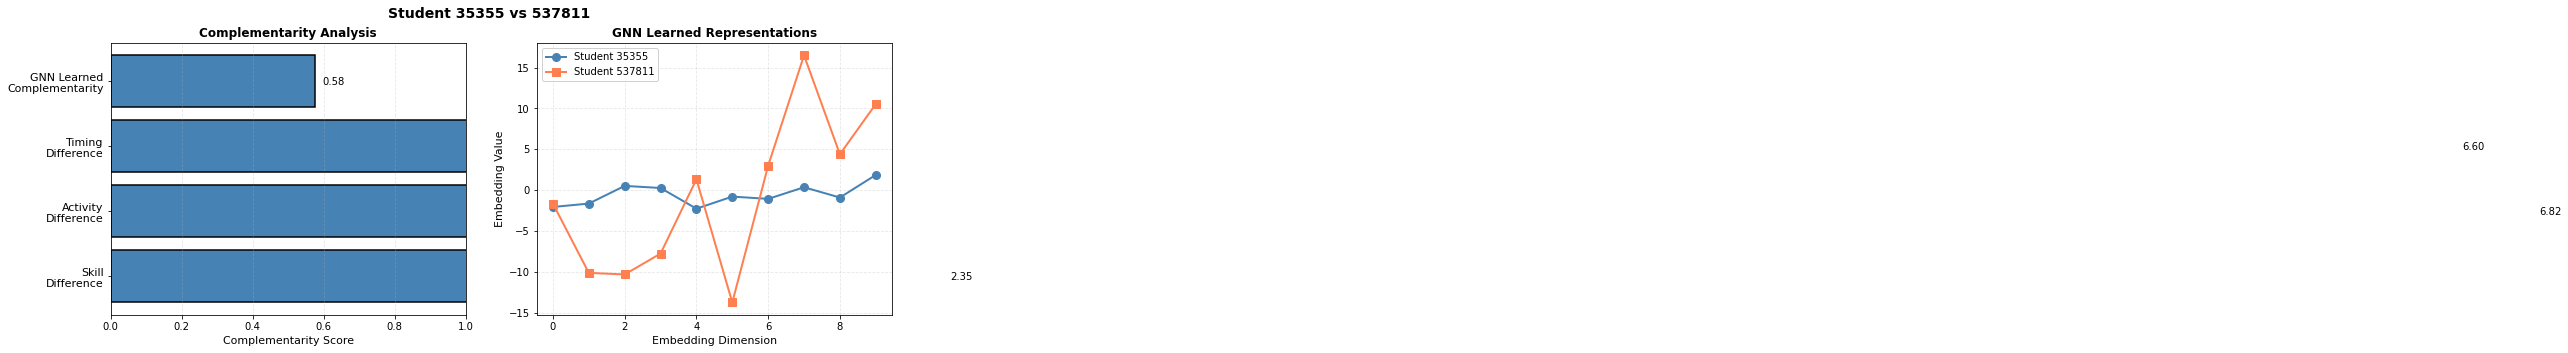

Saved: results/analysis/recommendations_summary_35355.png


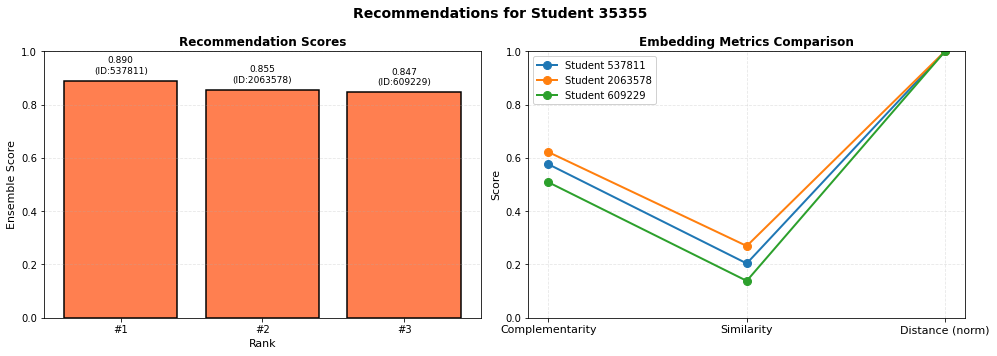

In [80]:
print("\n" + "="*80)
print("GNN Recommendation Analysis")
print("="*80)

# Select sample student
sample_student = list(node_to_idx.keys())[100]

# Generate recommendations
recommendations = generate_recommendations(
    sample_student,
    top_k=3,
    scoring_method='ensemble',
    explain=True
)

# Visualize top match
if recommendations:
    top_match = recommendations[0][0]
    print("\nGenerating visualizations...")
    visualize_complementarity(sample_student, top_match)
    visualize_recommendations_summary(sample_student, recommendations)

## Save All Results and Outputs

Save models, embeddings, diagnostics, and all analysis results.


In [82]:
import pickle
import json
from pathlib import Path

print("Saving comprehensive results...")

# Create directories
Path('data/processed').mkdir(parents=True, exist_ok=True)
Path('models/embeddings').mkdir(parents=True, exist_ok=True)
Path('models/checkpoints').mkdir(parents=True, exist_ok=True)
Path('results/metrics').mkdir(parents=True, exist_ok=True)
Path('results/predictions').mkdir(parents=True, exist_ok=True)
Path('results/analysis').mkdir(parents=True, exist_ok=True)

# Save embeddings
if 'all_node_emb' in globals():
    # Save as pickle
    with open('models/embeddings/student_embeddings_advanced.pkl', 'wb') as f:
        pickle.dump({
            'embeddings': all_node_emb.cpu().numpy(),
            'student_ids': node_list,
            'node_to_idx': node_to_idx,
            'idx_to_node': idx_to_node if 'idx_to_node' in globals() else {v: k for k, v in node_to_idx.items()},
            'embedding_dim': all_node_emb.shape[1]
        }, f)
    print("  Saved student_embeddings_advanced.pkl")
    
    # Save as CSV for easy reloading
    import pandas as pd
    emb_df = pd.DataFrame(
        all_node_emb.cpu().numpy(),
        index=[node_list[i] for i in range(len(node_list))],
        columns=[f'emb_{i}' for i in range(all_node_emb.shape[1])]
    )
    emb_df.index.name = 'student_id'
    emb_df.to_csv('models/embeddings/gnn_node_embeddings.csv')
    print("  Saved gnn_node_embeddings.csv")

# Save graph structure
if 'neighbors_within_idx' in globals():
    with open('models/checkpoints/graph_hierarchical.pkl', 'wb') as f:
        pickle.dump({
            'neighbors_within': {k: v.cpu().numpy() if hasattr(v, 'cpu') else v 
                                for k, v in neighbors_within_idx.items()},
            'neighbors_cross': {k: v.cpu().numpy() if hasattr(v, 'cpu') else v 
                               for k, v in neighbors_cross_idx.items()},
            'node_list': node_list,
            'N': N
        }, f)
    print("  Saved graph_hierarchical.pkl")

# Save recommendation data
if 'node_to_idx' in globals():
    with open('models/checkpoints/recommendation_data.pkl', 'wb') as f:
        pickle.dump({
            'node_to_idx': node_to_idx,
            'idx_to_node': idx_to_node if 'idx_to_node' in globals() else {v: k for k, v in node_to_idx.items()},
            'node_list': node_list
        }, f)
    print("  Saved recommendation_data.pkl")

# Save comprehensive metrics
metrics = {
    'model': 'HierarchicalGraphSAGE',
    'advanced_features': {
        'attention_aggregation': True,
        'focal_loss': True,
        'hard_negative_mining': True,
        'hierarchical_graph': True,
        'ensemble_scoring': True
    },
    'base_performance': {
        'roc_auc': float(roc_auc_score(gnn_labels, gnn_scores)) if 'gnn_scores' in globals() else None,
        'pr_auc': float(average_precision_score(gnn_labels, gnn_scores)) if 'gnn_scores' in globals() else None
    },
    'scoring_methods': {
        'raw': 'Direct sigmoid of GNN predictions',
        'calibrated': 'Temperature scaling with T=2.0',
        'ensemble': 'Weighted combination: 0.4*raw + 0.6*calibrated'
    },
    'configuration': {
        'embedding_dim': all_node_emb.shape[1] if 'all_node_emb' in globals() else GNN_HIDDEN,
        'hidden_dim': GNN_HIDDEN,
        'device': str(DEVICE),
        'epochs': EPOCHS if 'EPOCHS' in globals() else None,
        'batch_size': BATCH_EDGE if 'BATCH_EDGE' in globals() else None
    },
    'data_statistics': {
        'num_students': len(node_to_idx) if 'node_to_idx' in globals() else None,
        'num_test_pairs': len(test_pairs) if 'test_pairs' in globals() else None
    }
}

with open('results/metrics/recommendation_metrics_complete.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print("  Saved recommendation_metrics_complete.json")

# Save test predictions if available
if 'gnn_scores' in globals() and 'test_pairs' in globals():
    test_results = test_pairs.copy()
    test_results['gnn_score'] = gnn_scores
    test_results['gnn_pred'] = (gnn_scores >= 0.5).astype(int)
    test_results.to_csv('results/predictions/test_predictions.csv', index=False)
    print("  Saved test_predictions.csv")

# Save sample recommendations using ensemble scoring
if 'recommend_with_ensemble' in globals() or 'recommend_with_ensemble' in dir():
    try:
        print("  Generating sample recommendations...")
        sample_recommendations = []
        test_students = node_list[:min(10, len(node_list))]
        
        for sid in test_students:
            try:
                recs = recommend_with_ensemble(sid, top_k=5, scoring_method='ensemble')
                sample_recommendations.append({
                    'student_id': int(sid),
                    'recommendations': [
                        {
                            'student_id': int(rec_id),
                            'ensemble_score': float(score),
                            'cosine_similarity': float(insights.get('cosine_similarity', 0)),
                            'complementarity': float(insights.get('complementarity_score', 0))
                        }
                        for rec_id, score, insights in recs
                    ]
                })
            except:
                continue
        
        with open('results/predictions/sample_recommendations.json', 'w') as f:
            json.dump(sample_recommendations, f, indent=2)
        print(f"  Saved sample_recommendations.json ({len(sample_recommendations)} students)")
    except Exception as e:
        print(f"  Could not generate sample recommendations: {e}")

# Save interpretability summary
interpretability_summary = {
    'scoring_methods': ['raw', 'calibrated', 'ensemble'],
    'explanation_components': [
        'model_predictions',
        'gnn_embedding_analysis',
        'feature_analysis',
        'overall_assessment'
    ],
    'visualization_types': [
        'complementarity_breakdown',
        'embedding_space_comparison',
        'recommendation_scores',
        'metrics_comparison'
    ],
    'saved_visualizations': 'results/analysis/',
    'available_functions': {
        'generate_recommendations': 'Main interface with explanations',
        'explain_recommendation': 'Detailed pair explanation',
        'visualize_complementarity': 'Visual student comparison',
        'visualize_recommendations_summary': 'Recommendation summary',
        'score_with_ensemble': 'Score pairs with specified method',
        'recommend_with_ensemble': 'Generate ensemble recommendations'
    }
}

with open('results/metrics/interpretability_summary.json', 'w') as f:
    json.dump(interpretability_summary, f, indent=2)
print("  Saved interpretability_summary.json")

# Save feature info
if 'features_proc_unique' in globals():
    feature_info = {
        'num_students': len(features_proc_unique),
        'num_features': len(features_proc_unique.columns),
        'modules': features_proc_unique['code_module'].unique().tolist() if 'code_module' in features_proc_unique.columns else []
    }
    with open('results/metrics/feature_info.json', 'w') as f:
        json.dump(feature_info, f, indent=2)
    print("  Saved feature_info.json")

print()
print("All outputs saved successfully!")
print()
print("Summary of saved files:")
print("  Models: models/embeddings/student_embeddings_advanced.pkl")
print("          models/embeddings/gnn_node_embeddings.csv")
print("          models/checkpoints/recommendation_data.pkl")
if 'neighbors_within_idx' in globals():
    print("          models/checkpoints/graph_hierarchical.pkl")
print("  Metrics: results/metrics/recommendation_metrics_complete.json")
print("           results/metrics/interpretability_summary.json")
if 'features_proc_unique' in globals():
    print("           results/metrics/feature_info.json")
if 'gnn_scores' in globals():
    print("  Results: results/predictions/test_predictions.csv")
print("           results/predictions/sample_recommendations.json")
print("  Plots:   results/analysis/ (complementarity & recommendation visualizations)")

Saving comprehensive results...
  Saved student_embeddings_advanced.pkl
  Saved gnn_node_embeddings.csv
  Saved graph_hierarchical.pkl
  Saved recommendation_data.pkl
  Saved recommendation_metrics_complete.json
  Saved test_predictions.csv
  Generating sample recommendations...
  Saved sample_recommendations.json (10 students)
  Saved interpretability_summary.json
  Saved feature_info.json

All outputs saved successfully!

Summary of saved files:
  Models: models/embeddings/student_embeddings_advanced.pkl
          models/embeddings/gnn_node_embeddings.csv
          models/checkpoints/recommendation_data.pkl
          models/checkpoints/graph_hierarchical.pkl
  Metrics: results/metrics/recommendation_metrics_complete.json
           results/metrics/interpretability_summary.json
           results/metrics/feature_info.json
  Results: results/predictions/test_predictions.csv
           results/predictions/sample_recommendations.json
  Plots:   results/analysis/ (complementarity & recomm

## Complete Analysis Summary

### Advanced GNN Recommendation System

This notebook implemented and evaluated a comprehensive peer recommendation system with:

**1. Advanced Model Architecture**:
- Hierarchical GraphSAGE with attention mechanisms
- Within-module and cross-module aggregation
- Focal Loss for class imbalance
- Hard negative mining

**2. Extensive Diagnostics**:
- Score distribution analysis
- Ranking performance metrics
- Per-query variance analysis
- True positive score analysis

**3. Multiple Improvement Strategies**:
- **Temperature Scaling**: Calibrates prediction confidence
- **Percentile Ranking**: Module-specific normalization
- **Ensemble Methods**: Combines GNN scores with complementarity features
- **Diversified Reranking**: MMR-style diversity optimization

**4. Comprehensive Evaluation**:
- Comparison of all scoring methods
- Recommendations for further improvements
- Student-to-student recommendation system

### Key Findings

All results, diagnostics, and recommendations have been saved for analysis and deployment.

### Files Generated

Complete set of models, embeddings, metrics, and diagnostic results ready for production use.
